Outreachy 2021 \
Ioanna Siaminou (Nina)\
outreachy-datascience-2021 - Mozilla

Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kruskal, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
import mpld3

The given dataset contains information concerning houses and their corresponding sale price.

In more detail, the feature columns of the dataset represent various features for a house property like the LotArea, Street, Availability of a fireplace etc.

Our goal is to perform explanatory analysis on the given data, identify relations between the available features and try to find the field that is closely related to the sale price for each house.

From now on, columns will be denoted as features and rows as houses.

The workflow will be:
 1. Identify the type of the feature variables (numeric, categorical)
 2. Clean the data:
     - Find the missing data.
     - Deal with outliers
 3. Visualize the data, to gain intuition on the data.
     - Univariate Analysis
     - Bivariate Analysis with feature variables

In [2]:
# Auxiliary Functions

In [3]:
# Define auxiliary functions
def check_null_numeric(dataset):
    # Missing entries on the numeric feature variables
    numeric_feats = dataset.dtypes != object
    numeric_feats_l = dataset.columns[numeric_feats.to_list()]
    null_values_per_feat = dataset[numeric_feats_l].isnull().sum(axis=0)
    print(null_values_per_feat)
    return numeric_feats_l.to_list(), null_values_per_feat[null_values_per_feat > 0].index 

# Encode ordinal feature variables
def encode_ordinal_feats(dataset):
    # first, find the categorical variables
    categorical_feats = dataset.columns[(dataset.dtypes == object).to_list()]
#     for feat in categorical_feats:
#         print(f"{feat}: {dataset[feat].unique()}")
    
    mapper = {'LotShape': {'IR3': 4, 'IR2': 3, 'IR1': 2, 'Reg': 1},
              'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
              'ExterQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
              'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
              'BsmtQual': {'Not available': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
              'BsmtCond': {'Not available': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4},
              'BsmtExposure': {'Not available': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
              'BsmtFinType1': {'Not available': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
              'BsmtFinType2': {'Not available': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
              'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
              'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
              'Functional': {'Typ': 1, 'Min1': 2, 'Min2': 3, 'Mod': 4, 'Maj1': 5, 'Maj2': 6, 'Sev': 7},
              'FireplaceQu': {'Not available': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
              'GarageQual': {'Not available': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
              'GarageCond': {'Not available': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
              'PoolQC': {'Not available': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}             
              }
    
    dataset.replace(mapper, inplace=True)
    return mapper.keys()  # return the ordinal values
    
def plot_feature_var(dataset, type_of_variable):
    plt.rcParams.update({'figure.max_open_warning': 0})
    # For loop to scatter plot all the feature variables vs Saleprice
    # fig, ax = plt.subplots(len(type_of_variable), 1,figsize=(5,5))
    # i = 0
    for feat in type_of_variable:
        plt.figure()
        if feat != 'SalePrice':
            sns.scatterplot(x=feat, y="SalePrice", data=dataset)

            
def impute_num_vals(dataset, column, strategy='median'): # median as default
    # impute the numeric variables
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer.fit(dataset[column].to_numpy().reshape(-1, 1))
    dataset[column] = imputer.transform(dataset[column].values.reshape(-1, 1))
    return dataset

# maybe for future use
def outliers_iqr(dataset, col):
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1    
    filter = (dataset[col] >= Q1 - 1.5 * IQR) & (dataset[col] <= Q3 + 1.5 *IQR)
    print(f"Percentage of identified outliers: {filter[filter == False].count()}")
    return dataset.loc[filter]

# KW test
def KW_test(categorical_feat, dataset_sk):
    statisticfloats = []
    p_values = []
    for feat in categorical_feat:                                  # for all categorical features
        feat_groups = list(dataset_sk[feat].unique())   
        populations = []
        # save the different groups of the variable
        for g in feat_groups:
            # find the values in each group
            group_vals = dataset_sk[dataset_sk[feat] == g]['SalePrice'].to_numpy()
            populations.append(group_vals)
        statisticfloat, p_value = kruskal(*populations)                                     # unpack our arguments
        statisticfloats.append(statisticfloat)
        p_values.append(p_value)
    result = pd.DataFrame({'variable': categorical_feat, 'statistics': statisticfloats, 'p_values': p_values})
    return result

#  Data Loading and Inspection

In [4]:
# Set the seed
np.random.seed(0)

# Load the dataset 
dataset = pd.read_csv('dataset.csv')
# Take a look at the dataset
dataset.head(10)

dataset.shape

(1460, 81)

The dataset consists of 1460 rows and 81 feature columns. Some columns seem to have a lot of NaN values, which should be addressed according the application and the data. For example, in some cases we can fill them using information from the adjacent cells or even drop them all together.

In [5]:
# Print the summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Our Dataset consists of:  

- Νumeric   feature variables (38) -> dtype: float64, int64, 
- Categorical feature variables (43) -> dtype: object
    - Nominal Categorical Variables like the Neighborhood feature Variable
    - Ordinal Categorical Variables with the ordering: eg:['Poor', 'Fair', 'Typical', 'Good', 'Excellent']
        (In some cases 'NA' is available)

# Treat Missing Values

Initially, as a first step we check if there are duplicate houses by accident in the dataset. Then, houses which contain only NA values (if they exist). 

In [6]:
# unique ids
duplicates = dataset.duplicated().sum()  
print(f"DUPLICATES: {duplicates}")

# Drop NA on rows with no data
dataset = dataset.dropna(how='all')

DUPLICATES: 0


In [7]:
# Drop ID column as it does not provide information
dataset.drop(columns='Id', axis=1, inplace=True)

In [8]:
# count the missing values of the dataset
null_values = pd.DataFrame(dataset.count(), columns=['count'])
null_values['percentage(%)'] = (1 - null_values['count'] / dataset.shape[0]) * 100
null_values.reset_index(inplace=True)
null_values = null_values.rename(columns={'index': 'Feature Variables'})
num_na_cols = (null_values['count'] < dataset.shape[0]).sum()
print(f"Number of feature columns with missing values: {num_na_cols}")
null_values.sort_values(by='count').head(num_na_cols)

Number of feature columns with missing values: 19


Feature Variables  count  percentage(%)
71            PoolQC      7      99.520548
73       MiscFeature     54      96.301370
5              Alley     91      93.767123
72             Fence    281      80.753425
56       FireplaceQu    770      47.260274
2        LotFrontage   1201      17.739726
57        GarageType   1379       5.547945
58       GarageYrBlt   1379       5.547945
62        GarageQual   1379       5.547945
63        GarageCond   1379       5.547945
59      GarageFinish   1379       5.547945
31      BsmtExposure   1422       2.602740
34      BsmtFinType2   1422       2.602740
32      BsmtFinType1   1423       2.534247
30          BsmtCond   1423       2.534247
29          BsmtQual   1423       2.534247
25        MasVnrArea   1452       0.547945
24        MasVnrType   1452       0.547945
41        Electrical   1459       0.068493

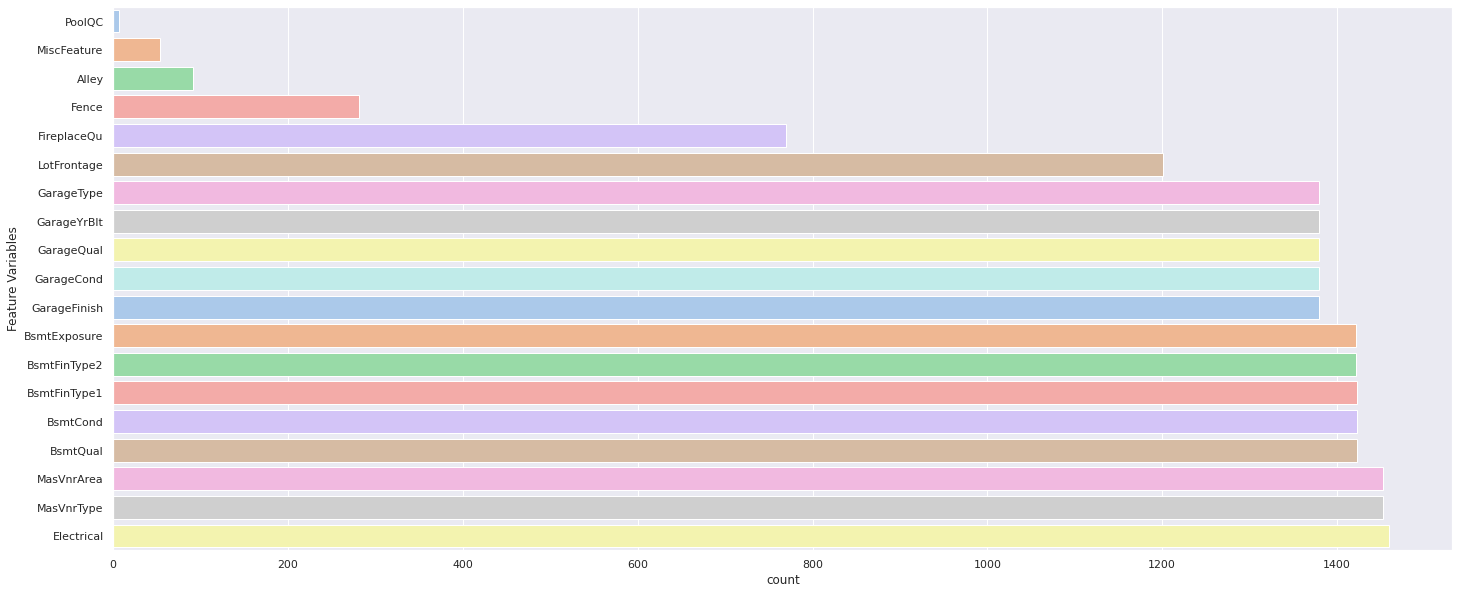

In [9]:
# visualize the number of missing values for each feature variable
plt.figure(figsize=(24, 10))
sns.set(style='darkgrid', color_codes=True)
sns.barplot(y='Feature Variables', x='count',  palette='pastel', data=null_values.sort_values(by='count').head(num_na_cols))


The entry NA should be interpreted differently for two types of variables.
According to data description file, NA for categorical feature variables means
no availability of the corresponding feature (No fireplace, No basement etc).  Note: Electrical does not have Not Available class, thus the house where at Electrical feature column has NA is dropped.

However, NA for numeric values is interpreted as a missing entry. 
In the following block of code, the missing entries for the numeric variables are counted.

In [10]:
# Drop NA on numerical columns
dataset.dropna(subset=['Electrical'], inplace=True)

  - Missing entries for the numeric feature variables:

In [11]:
# Missing entries on the numeric feature variables
numeric_feats, num_na_values = check_null_numeric(dataset)
num_na_values.to_list()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64


['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

Since MasVnrArea, GarageYrBlt contain less than 10% of missing values, we can use an imputation method to fill the missing values. First, we check if our data are skewed to determine if mean or median imputation method will be used.

The mean of LotFrontage is 70.0475


<Figure size 3168x2880 with 0 Axes>

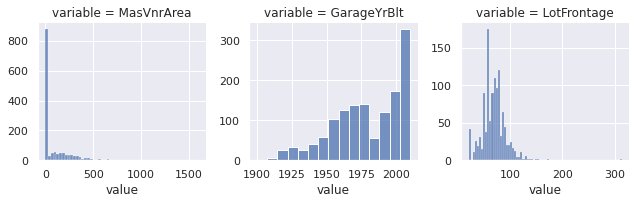

In [12]:
# Visualizing the skewness for MasVnrArea, GarageYrBlt feature variables.
plt.figure(figsize=(44, 40))
g = sns.FacetGrid(pd.melt(dataset, value_vars=['MasVnrArea', 'GarageYrBlt', 'LotFrontage']), col_wrap=3, col="variable", sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

print(f"The mean of LotFrontage is {dataset['LotFrontage'].mean()}")

The feature variables MasVnrArea and GarageYrBlt are positive(right) and negative(left) skewed, respectively, thus we will use median imputer instead of the mean.

In [13]:
# Impute the feature column MasVnrArea
dataset = impute_num_vals(dataset, strategy='median', column='MasVnrArea')
# Impute the feature column GarageYrBlt
dataset = impute_num_vals(dataset, strategy='median', column='GarageYrBlt')

Variable LotFrontage has ~ 17% missing variables thus, a different method is used to estimate the missing values.
Note that variable LotFrontage is more symmetric than the other two variables.

A regression method is used compared with the median method. We choose median since it is more robust on outliers. 

In [14]:
# Compare mean and BayesianRidge or # ExtraTreesRegressor
df_bayes = dataset.copy(deep=True)
imputer = IterativeImputer(BayesianRidge(), missing_values=np.nan)
imputer.fit(df_bayes['LotFrontage'].to_numpy().reshape(-1, 1))
df_bayes['LotFrontage'] = imputer.transform(df_bayes['LotFrontage'].values.reshape(-1, 1))

df_mean = dataset.copy(deep=True)
impute_num_vals(df_mean, strategy='median', column='LotFrontage')

data = [df_bayes['LotFrontage'], df_mean['LotFrontage']]
headers = ["LotFrontage_bayes", "LotFrontage_mean"]

comp_imputer = pd.concat(data, axis=1, keys=headers)

Check again the distribution of the imputed variables

<Figure size 3168x2880 with 0 Axes>

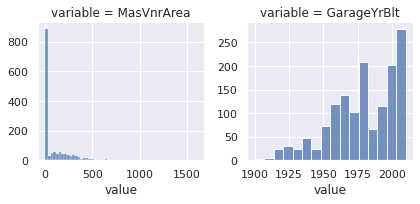

In [15]:
# After the imputation MasVnrArea, GarageYrBlt feature variables.
plt.figure(figsize=(44, 40))
g = sns.FacetGrid(pd.melt(dataset, value_vars=['MasVnrArea', 'GarageYrBlt']), col_wrap=2, col="variable", sharex=False, sharey=False)
g = g.map(sns.histplot, "value")

LotFrontage_bayes  LotFrontage_mean
count        1459.000000       1459.000000
mean           70.047500         69.861549
std            22.031439         22.035077
min            21.000000         21.000000
25%            60.000000         60.000000
50%            70.047500         69.000000
75%            79.000000         79.000000
max           313.000000        313.000000

<Figure size 3168x2880 with 0 Axes>

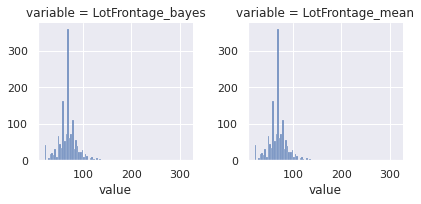

In [16]:
# Compare the imputation LotFeature feature variables.
plt.figure(figsize=(44, 40))
g = sns.FacetGrid(pd.melt(comp_imputer, value_vars=['LotFrontage_bayes', 'LotFrontage_mean']), col_wrap=2, col="variable", sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
comp_imputer.describe()

The effect of the different imputer methods seems very close. We will BayesianRidge since it is closer to actual mean.

Apply the BayesianRidge() to the actual dataset column.

In [17]:
print(type(imputer))
dataset['LotFrontage'] = imputer.transform(dataset['LotFrontage'].values.reshape(-1, 1))

<class 'sklearn.impute._iterative.IterativeImputer'>


Note that the methods used for the imputation can change, EDA is an iterative process. 


We replace the "NA" value on the Categorical Variables (Except for Electrical) as "Not Available"

In [18]:
dataset.fillna("Not available", inplace=True)
# Replace NA in Categorical data
dataset.tail(10)

MSSubClass MSZoning  LotFrontage  LotArea Street          Alley  \
1450          90       RL         60.0     9000   Pave  Not available   
1451          20       RL         78.0     9262   Pave  Not available   
1452         180       RM         35.0     3675   Pave  Not available   
1453          20       RL         90.0    17217   Pave  Not available   
1454          20       FV         62.0     7500   Pave           Pave   
1455          60       RL         62.0     7917   Pave  Not available   
1456          20       RL         85.0    13175   Pave  Not available   
1457          70       RL         66.0     9042   Pave  Not available   
1458          20       RL         68.0     9717   Pave  Not available   
1459          20       RL         75.0     9937   Pave  Not available   

     LotShape LandContour Utilities LotConfig  ... PoolArea         PoolQC  \
1450      Reg         Lvl    AllPub       FR2  ...        0  Not available   
1451      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1452      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1453      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1454      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1455      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1456      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1457      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1458      Reg         Lvl    AllPub    Inside  ...        0  Not available   
1459      Reg         Lvl    AllPub    Inside  ...        0  Not available   

              Fence    MiscFeature MiscVal MoSold  YrSold  SaleType  \
1450  Not available  Not available       0      9    2009        WD   
1451  Not available  Not available       0      5    2009       New   
1452  Not available  Not available       0      5    2006        WD   
1453  Not available  Not available       0      7    2006        WD   
1454  Not available  Not available       0     10    2009        WD   
1455  Not available  Not available       0      8    2007        WD   
1456          MnPrv  Not available       0      2    2010        WD   
1457          GdPrv           Shed    2500      5    2010        WD   
1458  Not available  Not available       0      4    2010        WD   
1459  Not available  Not available       0      6    2008        WD   

      SaleCondition  SalePrice  
1450         Normal     136000  
1451        Partial     287090  
1452         Normal     145000  
1453        Abnorml      84500  
1454         Normal     185000  
1455         Normal     175000  
1456         Normal     210000  
1457         Normal     266500  
1458         Normal     142125  
1459         Normal     147500  

[10 rows x 80 columns]

Check that we have no missing values

In [19]:
all(dataset.count() == dataset.shape[0])

True

We change the categorical values for the MSZoning accordingly
C (all) -> C

In [20]:
dataset['MSZoning'].replace("C (all)", 'C',inplace=True)

- *2nd Contribution*: It seems to work with relatively small datasets, at least in my system. However, it is very useful library for quick inspection on the data. 

In [21]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(dataset.sample(n=100), minimal=True)
# prof.to_file(output_file='output.html')

# Univariate Analysis

At first the ordinal categorical variables are encoded. The order of ordinal variables is preserved through the right assignment of integers eg Low - Medium - High -> 1 - 2 - 3. Not available is set to 0.

In [22]:
ord_feat = encode_ordinal_feats(dataset)

 - Visualizing nominal categorical feature variables.

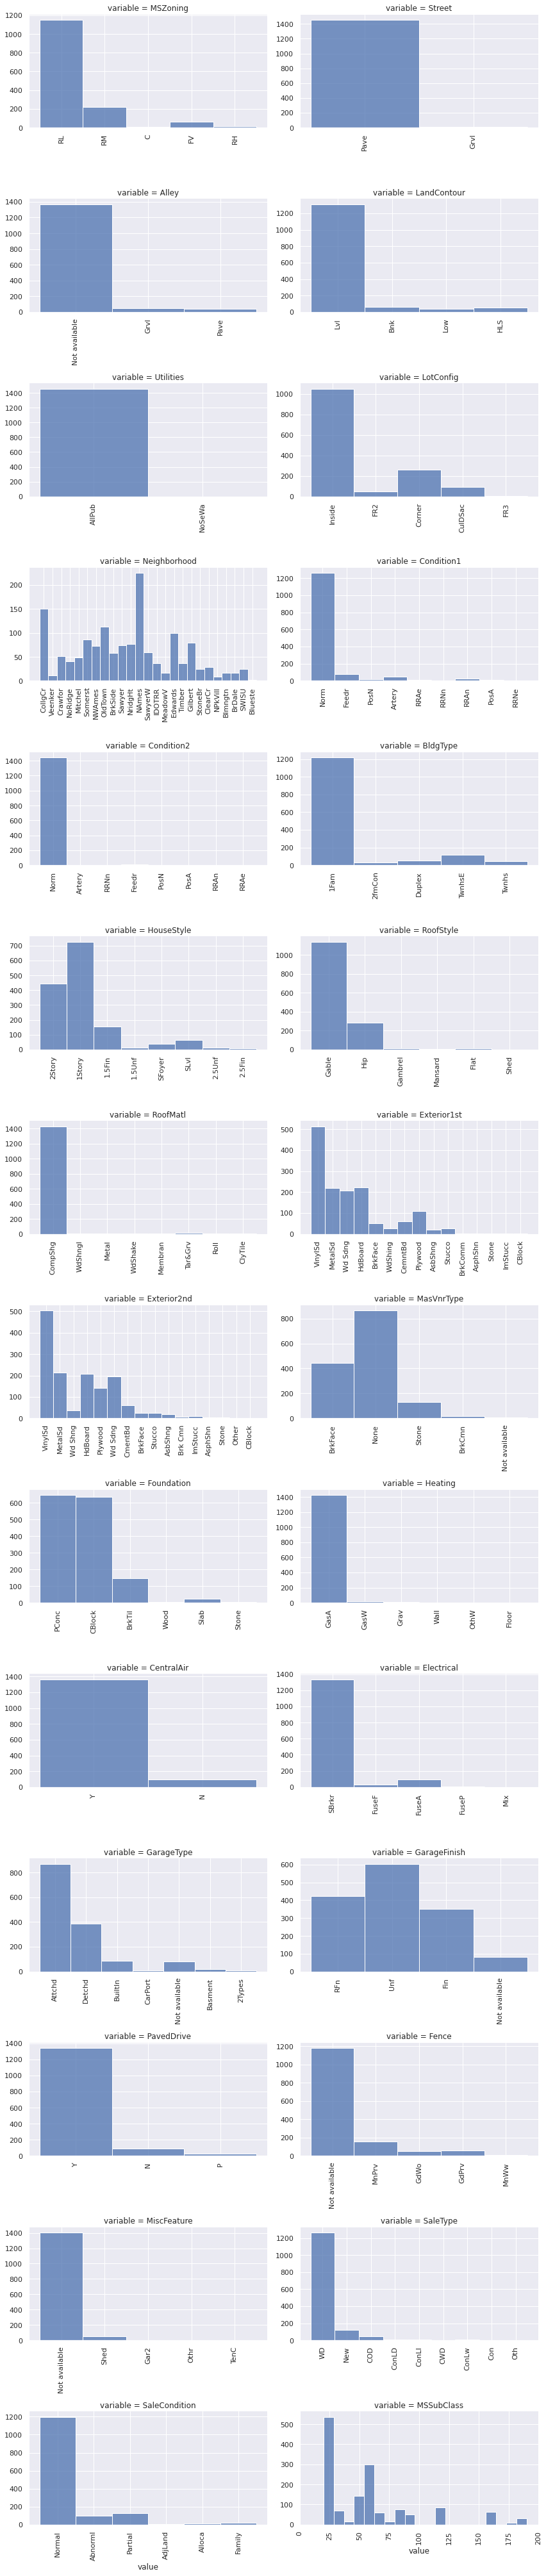

In [23]:
nominal_feat = dataset.columns[dataset.dtypes == object].to_list()
nominal_feat.append('MSSubClass')
dataset_cat = dataset[nominal_feat]


g = sns.FacetGrid(pd.melt(dataset_cat, value_vars=nominal_feat), col_wrap=2, aspect=1.5, height=4, col="variable", sharex=False, sharey=False)
g = g.map(sns.histplot, "value")
g.set_xticklabels(rotation=90)
g.fig.tight_layout()

A quick observation from looking the histograms for the nominal categorical variables is that most of them are unbalanced. For example, the majority of the houses in the dataset have paved access to the property. Also, most of the available properties have roofs made from clay or tile. The available properties seem to spread to the available neighborhoods.


   - Visualizing the numerical feature variables (plus ordinal)  

The basic statistics for the numerical variables

In [24]:
summary = dataset.iloc[:, 1:].describe().transpose()
summary['skewness'] = dataset.iloc[:, 1:].skew()
summary

count           mean           std      min       25%  \
LotFrontage    1459.0      70.047500     22.031439     21.0      60.0   
LotArea        1459.0   10517.363948   9984.666267   1300.0    7549.0   
LotShape       1459.0       1.408499      0.582398      1.0       1.0   
LandSlope      1459.0       1.062371      0.276322      1.0       1.0   
OverallQual    1459.0       6.100069      1.383171      1.0       5.0   
OverallCond    1459.0       5.575737      1.113079      1.0       5.0   
YearBuilt      1459.0    1971.244003     30.199555   1872.0    1954.0   
YearRemodAdd   1459.0    1984.850583     20.644343   1950.0    1967.0   
MasVnrArea     1459.0     103.187800    180.773158      0.0       0.0   
ExterQual      1459.0       2.396162      0.574384      1.0       2.0   
ExterCond      1459.0       3.083619      0.351167      1.0       3.0   
BsmtQual       1459.0       2.514051      0.785003      0.0       2.0   
BsmtCond       1459.0       2.934887      0.552345      0.0       3.0   
BsmtExposure   1459.0       1.630569      1.067630      0.0       1.0   
BsmtFinType1   1459.0       3.547635      2.107443      0.0       1.0   
BsmtFinSF1     1459.0     443.943797    456.106417      0.0       0.0   
BsmtFinType2   1459.0       1.247430      0.892615      0.0       1.0   
BsmtFinSF2     1459.0      46.581220    161.369977      0.0       0.0   
BsmtUnfSF      1459.0     567.366004    441.992392      0.0     223.0   
TotalBsmtSF    1459.0    1057.891021    438.500975      0.0     796.0   
HeatingQC      1459.0       4.145305      0.959822      1.0       3.0   
1stFlrSF       1459.0    1162.906785    386.572089    334.0     882.0   
2ndFlrSF       1459.0     346.791638    436.610637      0.0       0.0   
LowQualFinSF   1459.0       5.848526     48.639512      0.0       0.0   
GrLivArea      1459.0    1515.546950    525.650927    334.0    1129.0   
BsmtFullBath   1459.0       0.425634      0.518969      0.0       0.0   
BsmtHalfBath   1459.0       0.057574      0.238830      0.0       0.0   
FullBath       1459.0       1.564770      0.550987      0.0       1.0   
HalfBath       1459.0       0.382454      0.502798      0.0       0.0   
BedroomAbvGr   1459.0       2.866347      0.816050      0.0       2.0   
KitchenAbvGr   1459.0       1.046607      0.220410      0.0       1.0   
KitchenQual    1459.0       2.511309      0.663864      1.0       2.0   
TotRmsAbvGrd   1459.0       6.517478      1.625902      2.0       5.0   
Functional     1459.0       1.158328      0.667914      1.0       1.0   
Fireplaces     1459.0       0.613434      0.644687      0.0       0.0   
FireplaceQu    1459.0       1.826594      1.810866      0.0       0.0   
GarageYrBlt    1459.0    1978.569568     23.993708   1900.0    1962.0   
GarageCars     1459.0       1.766964      0.747546      0.0       1.0   
GarageArea     1459.0     473.030158    213.869604      0.0     333.0   
GarageQual     1459.0       2.810144      0.723129      0.0       3.0   
GarageCond     1459.0       2.808773      0.719915      0.0       3.0   
WoodDeckSF     1459.0      94.240576    125.381679      0.0       0.0   
OpenPorchSF    1459.0      46.692255     66.267472      0.0       0.0   
EnclosedPorch  1459.0      21.969157     61.137400      0.0       0.0   
3SsnPorch      1459.0       3.411926     29.327247      0.0       0.0   
ScreenPorch    1459.0      15.071282     55.775138      0.0       0.0   
PoolArea       1459.0       2.760795     40.191018      0.0       0.0   
PoolQC         1459.0       0.009596      0.147837      0.0       0.0   
MiscVal        1459.0      43.518849    496.291826      0.0       0.0   
MoSold         1459.0       6.322824      2.704331      1.0       5.0   
YrSold         1459.0    2007.815627      1.328542   2006.0    2007.0   
SalePrice      1459.0  180930.394791  79468.964025  34900.0  129950.0   

                       50%       75%       max   skewness  
LotFrontage        70.0475      79.0     313.0   2.384513  
LotArea          9477.0000

From the above table, skewness is present in the majority of numerical feature columns. In the following blocks of code, we address that in order to facilitate the process of removing outliers in the following sections. 

In [25]:
# Right(positive) and left(negative) skewed feature columns
right_skewed = summary[summary['skewness'] > 0].index.to_list()
left_skewed = summary[summary['skewness'] < 0].index.to_list()
# Remove ordinal data
numeric_feats_s = set(numeric_feats)
right_skewed = list(set(right_skewed).intersection(numeric_feats_s))
left_skewed = list(set(left_skewed).intersection(numeric_feats_s))


In [26]:
# Right (positive) skewed
print(f"Right skewed: {right_skewed}")
# Left (negative) skewed
print(f"Left  skewed: {left_skewed}")

Right skewed: ['OpenPorchSF', 'BsmtFullBath', 'Fireplaces', 'PoolArea', 'LotArea', 'GarageArea', 'HalfBath', '1stFlrSF', 'LotFrontage', 'TotRmsAbvGrd', 'GrLivArea', 'BsmtUnfSF', 'MasVnrArea', 'MiscVal', 'SalePrice', 'WoodDeckSF', 'ScreenPorch', 'BsmtFinSF1', 'YrSold', 'EnclosedPorch', 'LowQualFinSF', 'BsmtHalfBath', 'OverallCond', '3SsnPorch', 'TotalBsmtSF', 'MoSold', 'BsmtFinSF2', 'BedroomAbvGr', '2ndFlrSF', 'KitchenAbvGr', 'OverallQual', 'FullBath']
Left  skewed: ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageCars']


Visualize the feature variables 

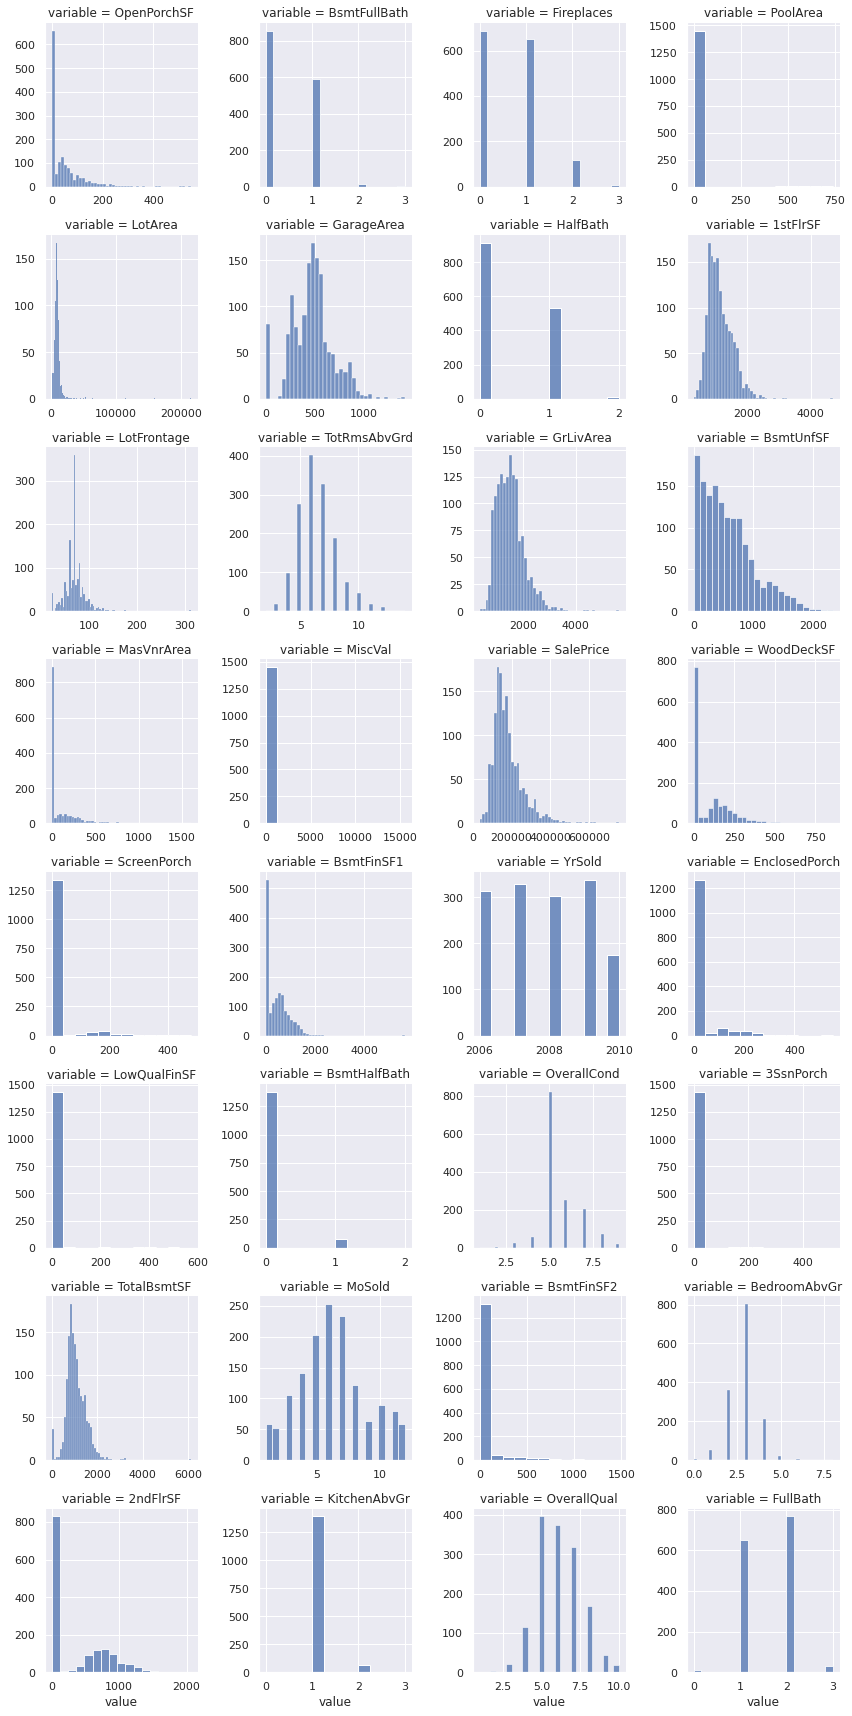

In [27]:
# Right skewness
if right_skewed:
    g = sns.FacetGrid(pd.melt(dataset, value_vars=right_skewed), col_wrap=4, col="variable", sharex=False, sharey=False)
    g = g.map(sns.histplot, "value")

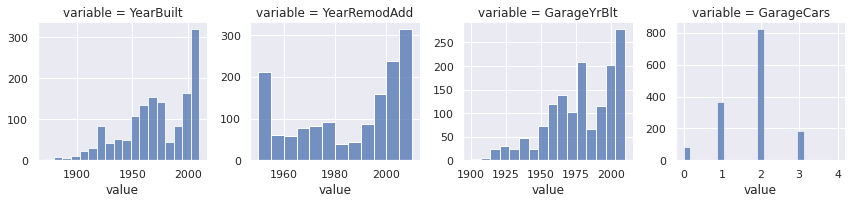

In [28]:
# Left skewness
if left_skewed:
    g = sns.FacetGrid(pd.melt(dataset, value_vars=left_skewed), col_wrap=4, col="variable", sharex=False, sharey=False)
    g = g.map(sns.histplot, "value")

Most feature columns are right skewed. The highly skewed feature columns are transformed.
We check log transformation for the feature variables. In Log Transform we have the formula (log(* + 1) to deal with nan values, it won't affect much). After inspection of the above figures, we will transform with the following method Note: corrected a typo: log() + 1 -> log(* + 1)
  - Log Transform 

In [29]:
# Log Transform
dataset_sk = dataset.copy(deep=True)
dataset_sk[right_skewed] = (1 + dataset_sk[right_skewed]).apply(np.log)
dataset_sk[left_skewed] = (1 + dataset_sk[left_skewed]).apply(np.log)

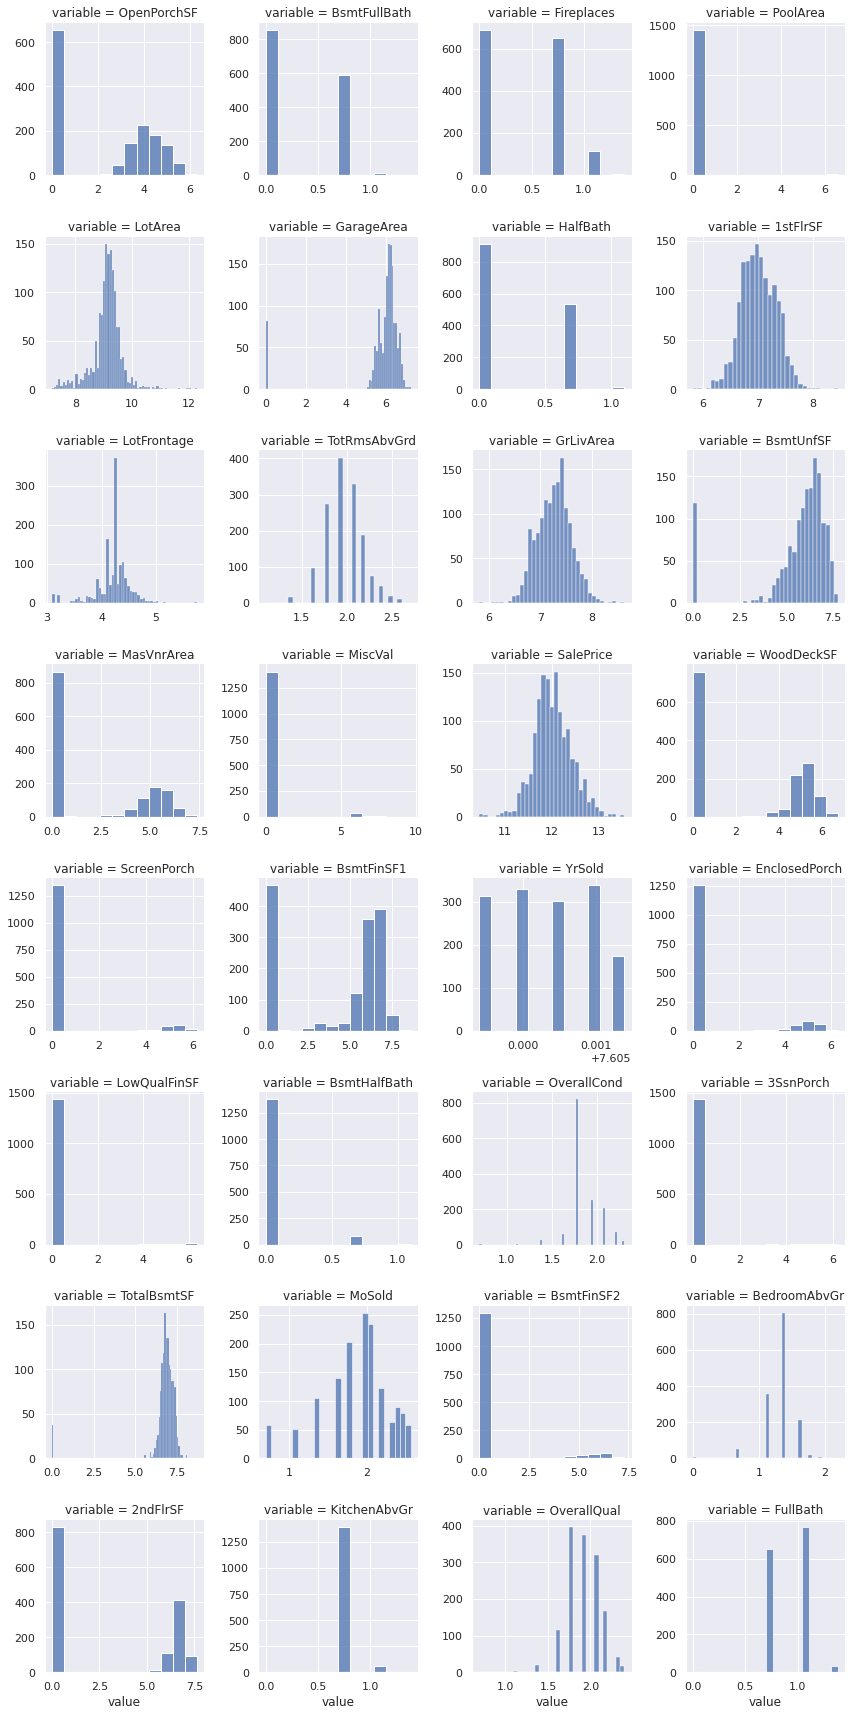

In [30]:
# Visualize after transform box plot to identify univariate outliers
if right_skewed:
    g = sns.FacetGrid(pd.melt(dataset_sk, value_vars=right_skewed), col_wrap=4, col="variable", sharex=False, sharey=False)
    g = g.map(sns.histplot, "value")


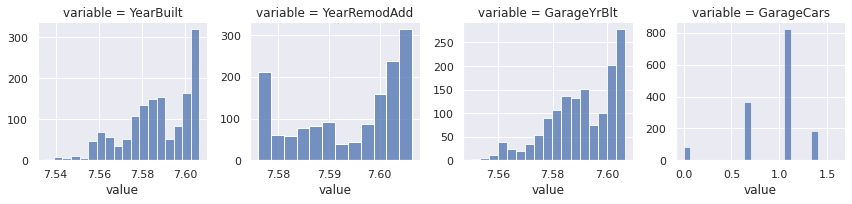

In [31]:
# Visualize after transform
if left_skewed:
    g = sns.FacetGrid(pd.melt(dataset_sk, value_vars=left_skewed), col_wrap=4, col="variable", sharex=False, sharey=False)
    g = g.map(sns.histplot, "value")


# Bivariate Analysis

Next, bivariate analysis follows. More specifically, each feature variable is visualized versus the target variable SalePrice in order to identify patterns and spot bivariate outliers.  

To identify the influence of the categorical features in the SalePrice variable, we will perform Kruskal Wallis H-test. Kruskal Wallis (also one-way ANOVA on ranks). Since it is not parametric (distribution free) it is more general than ANOVA (analysis of variance). Although, the target variable SalePrice is transformed via log transform, we will use the more general KW test.

 - Kruskal Wallis for identifying relationships for categorical and SalePrice

In [32]:
res = KW_test(nominal_feat, dataset_sk)      
res.sort_values(by='p_values')

variable  statistics       p_values
6    Neighborhood  868.588222  6.516987e-168
21   GarageFinish  609.773132  7.667989e-132
20     GarageType  532.905633  6.830971e-112
27     MSSubClass  531.127944  2.315267e-104
16     Foundation  488.600192  2.305310e-103
15     MasVnrType  281.876047   8.779966e-60
0        MSZoning  269.871059   3.400769e-57
13    Exterior1st  303.957339   1.767007e-56
14    Exterior2nd  284.157152   1.085295e-51
10     HouseStyle  185.251313   1.514233e-36
26  SaleCondition  168.248296   1.725091e-34
18     CentralAir  143.142147   5.472066e-33
25       SaleType  156.314457   9.424908e-30
19     Electrical  131.423013   1.932218e-27
22     PavedDrive  115.785846   7.201501e-26
23          Fence   77.915852   4.812720e-16
9        BldgType   69.739558   2.576180e-14
7      Condition1   74.336664   6.696776e-13
2           Alley   45.680445   1.203975e-10
3     LandContour   35.289053   1.058428e-07
11      RoofStyle   39.913419   1.554622e-07
5       LotConfig   35.719355   3.305025e-07
17        Heating   33.258473   3.343822e-06
12       RoofMatl   18.861092   8.633803e-03
8      Condition2   17.763125   1.308569e-02
24    MiscFeature   11.592962   2.064925e-02
1          Street    3.063160   8.008578e-02
4       Utilities    0.406412   5.237960e-01

<Figure size 3168x2880 with 0 Axes>

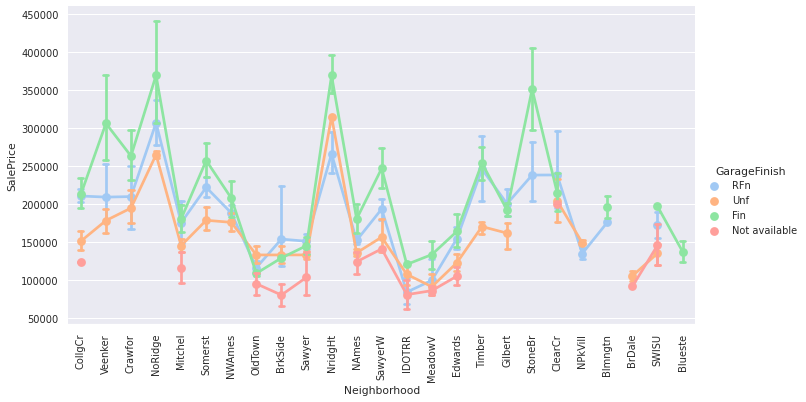

In [33]:
# Draw a pointplot to show pulse as a function of three categorical factors
plt.figure(figsize=(44, 40))
sns.set(font_scale=0.9)
g = sns.catplot(x="Neighborhood", y="SalePrice", hue="GarageFinish",
                capsize=.2, palette="pastel", height=5, aspect=1.95,
                kind="point", data=dataset)
g.despine(left=True)
g.set_xticklabels(rotation=90)

The Kruskal Wallis for each categorical variable will basically examine the hypothesis that a group of a categorical variable affects more the target variable SalePrice. If the p-value is less than or equal to a defined threshold (eg. 0.05), you reject the null hypothesis (the same effect on the target variable).

Then, the correlation between each variable with the target is calculated.
Spearman correlation metric is used since it does not assume distribution on the data. *Found an error dataset['SalePrice'] -> dataset_sk['SalePrice']*

In [34]:
corr = dataset_sk.iloc[:, 1:].corrwith(dataset_sk['SalePrice'], method='spearman').sort_values()  # exclude MSsubClass
corr = pd.DataFrame(index=corr.index, data=corr.values, columns=['correlation'])
corr = corr.drop(index='SalePrice')

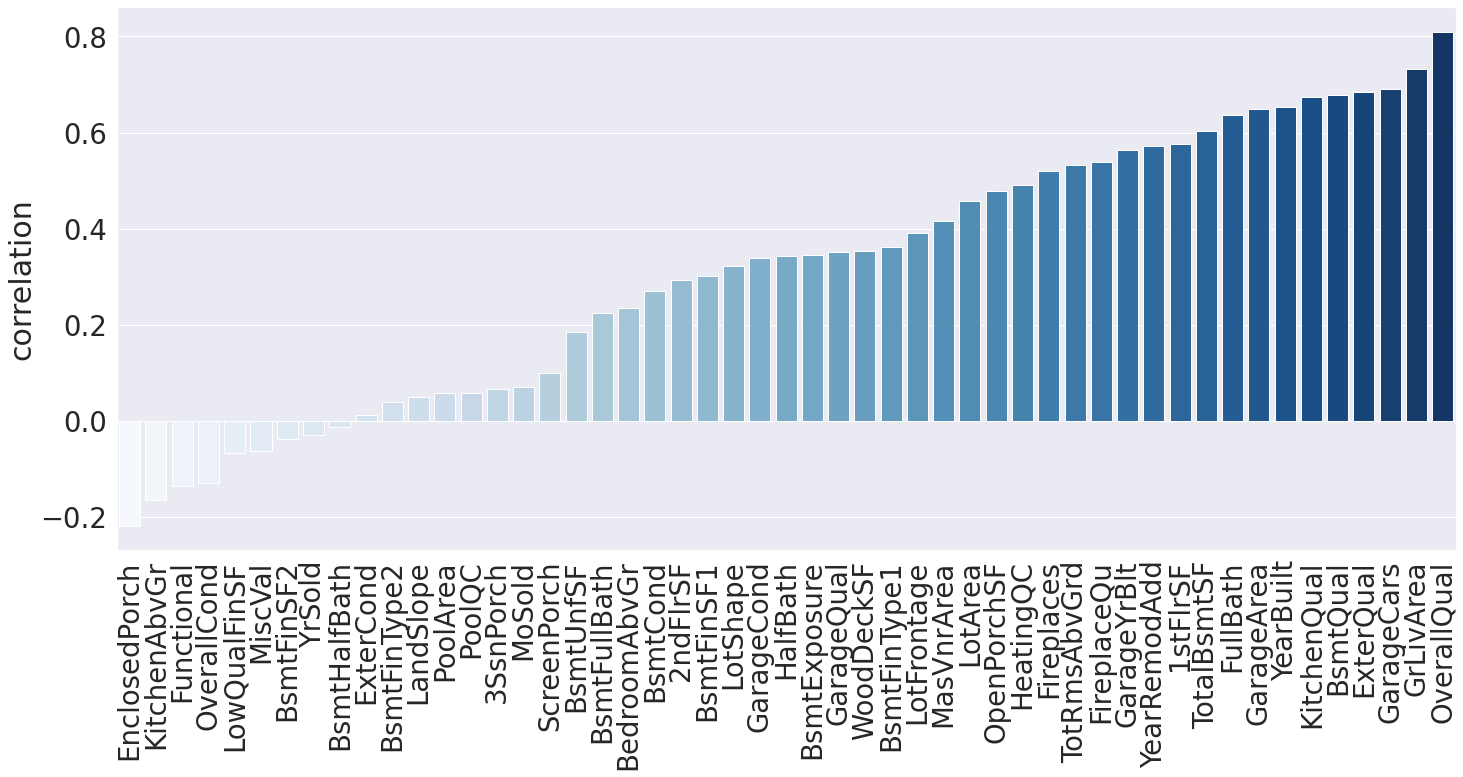

In [35]:
plt.figure(figsize=(24, 10))
sns.set(style="darkgrid", color_codes=True, font_scale=2.5)
g = sns.barplot(x=corr.index, y='correlation',  palette="Blues", data=corr)
_ = g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)

Overall, correlation between feature variables (numeric, ordinal)

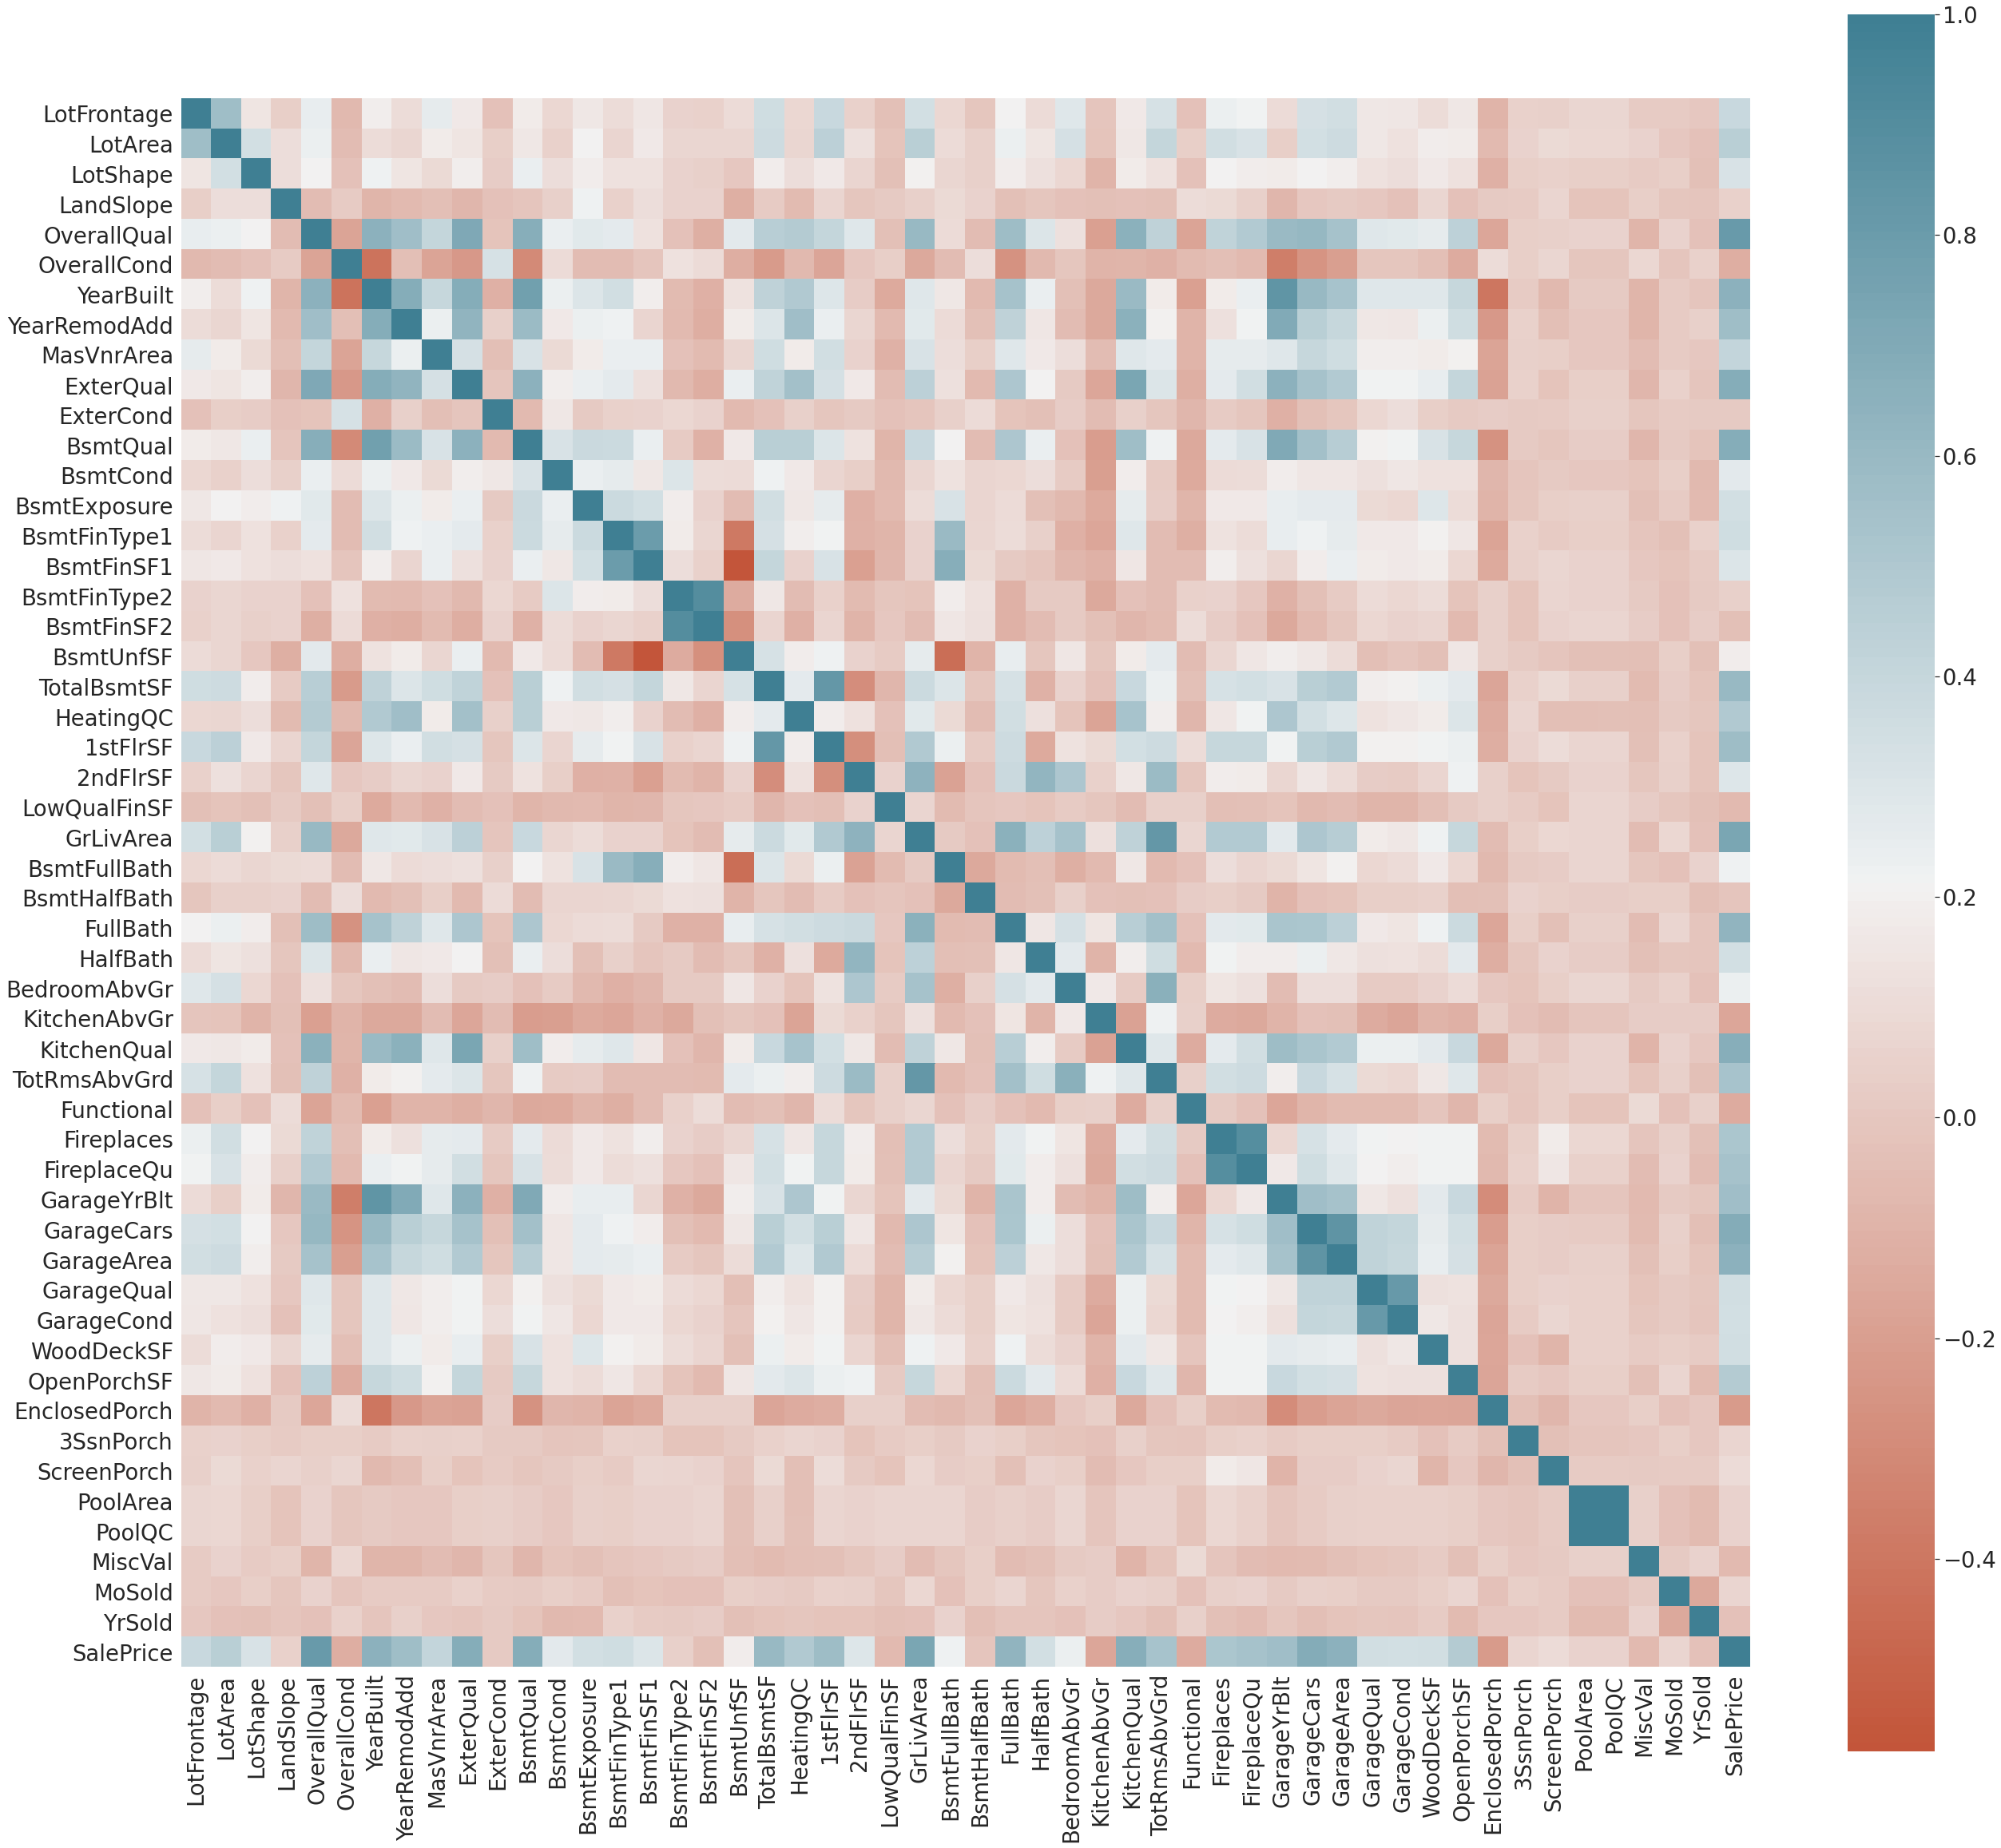

In [36]:
plt.figure(figsize=(44, 40))
sns.set(font_scale=2.5)
sns.heatmap(dataset_sk.iloc[:, 1:].corr(method='spearman'), annot=False, annot_kws={"size": 15}, cmap=sns.diverging_palette(20, 220, n=200), square=True)

The previous heatmap shows that several feature variables are pairwise correlated. For example, Fireplaces and FireplaceQu are highly correlated, which is pretty intuitive. However, the pair GrLivArea and TotRmsAbvGRd are also correlated, which is not very obvious relationship. This heatmap shows that our data may possess some relationships that are not so obvious sometimes. 

Visualize the pairs of feature column vs the SalePrice and try to identify outliers.

/home/nina/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


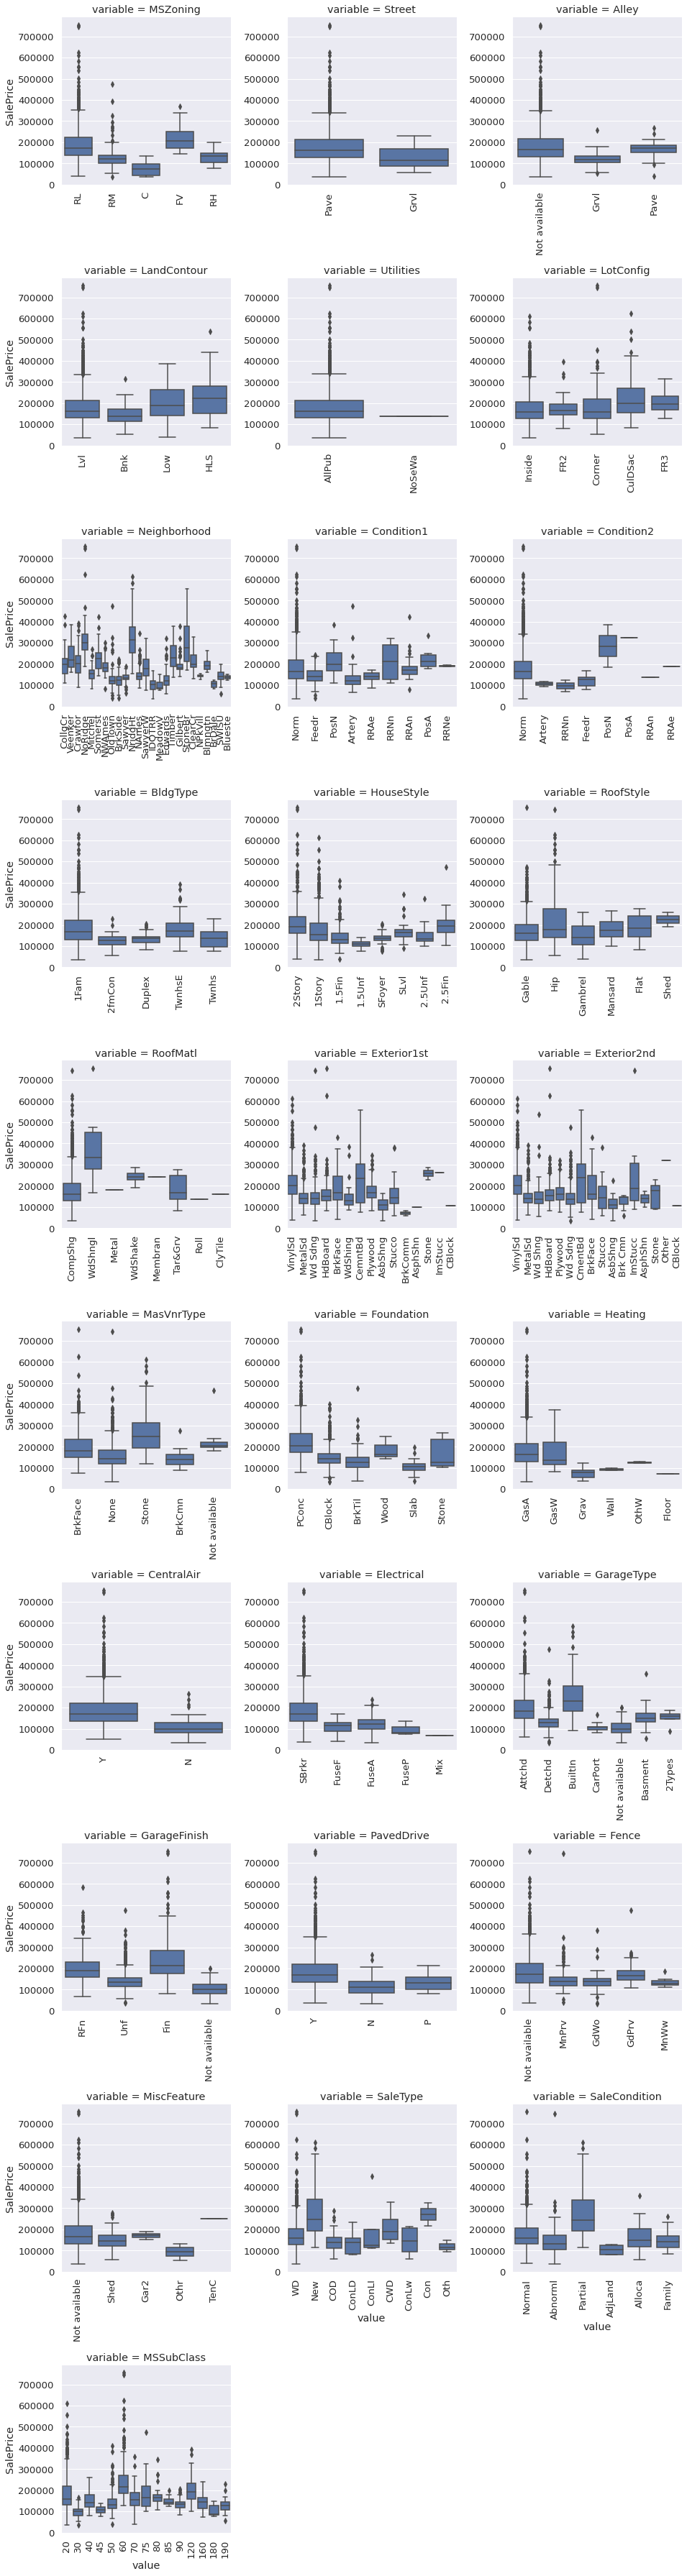

In [37]:
sns.set(font_scale=1.2)
f = pd.melt(dataset, id_vars=['SalePrice'], value_vars=nominal_feat)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5, aspect=0.9)
g = g.map(sns.boxplot, "value", "SalePrice")
g.set_xticklabels(rotation=90)
g.fig.tight_layout()

In categorical data we can not claim that a value is an outlier easily. The removal of any value can affect the performance of the model that will be used to fit the data. Outliers are not strictly defined and in most times are treated subjectively. Since, I do not have an intuition about what makes a value an outlier for these particular feature variables, I choose to keep them.

The visualization for numeric data follows

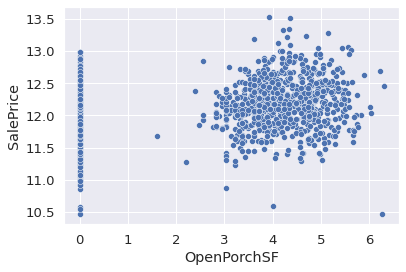

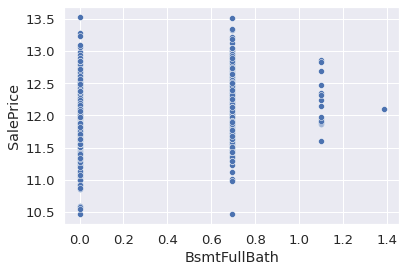

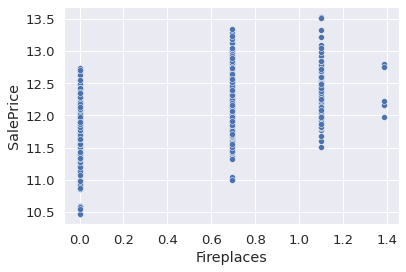

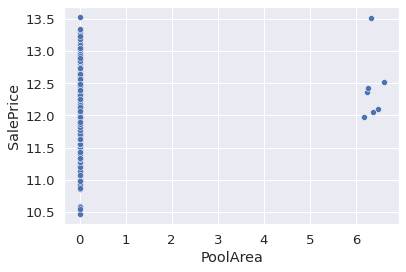

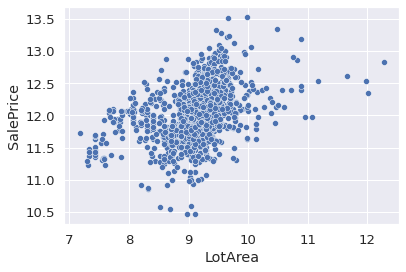

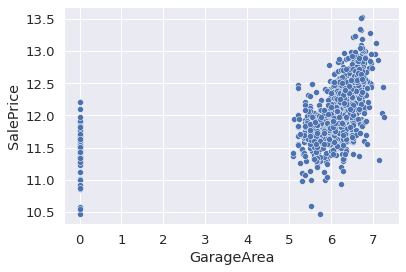

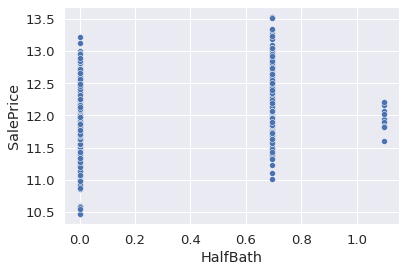

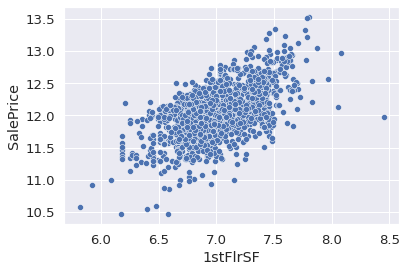

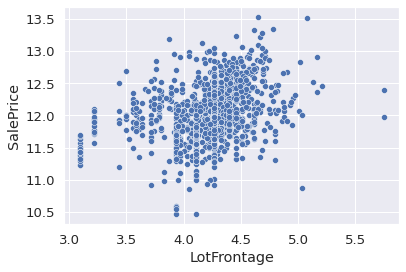

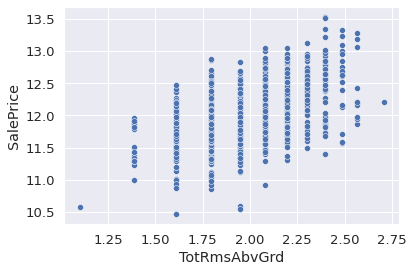

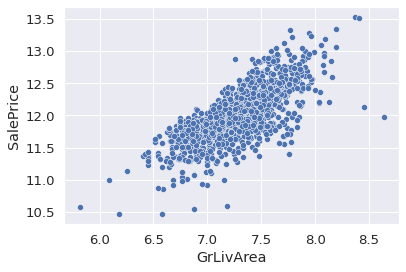

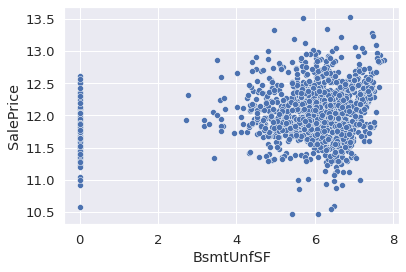

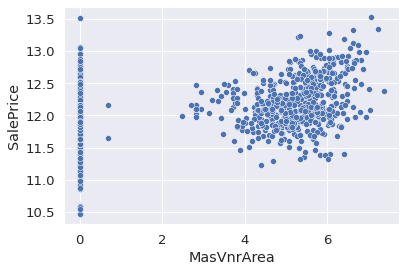

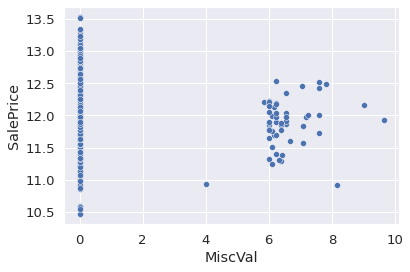

<Figure size 432x288 with 0 Axes>

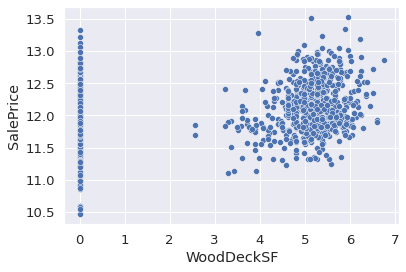

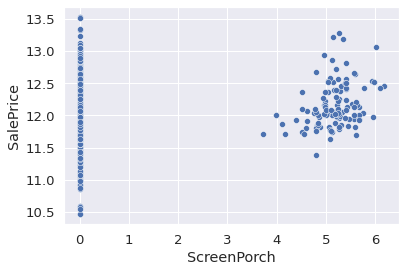

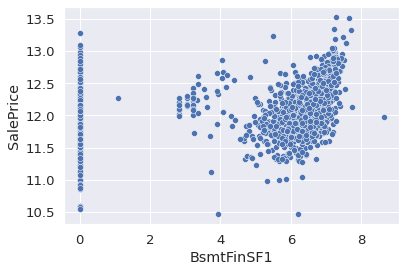

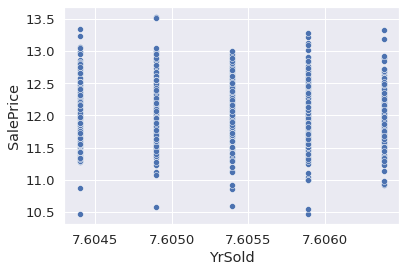

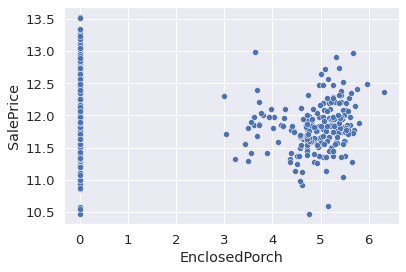

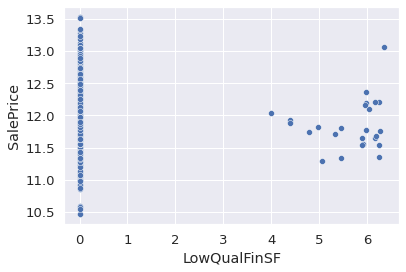

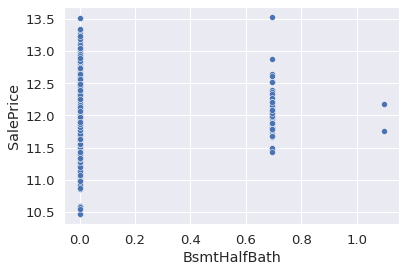

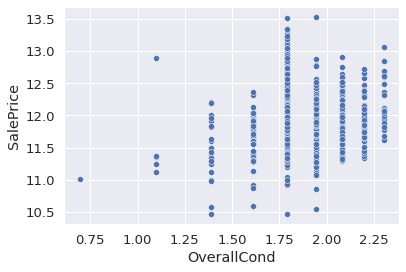

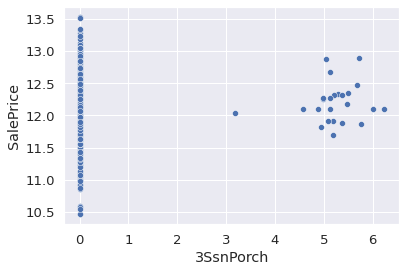

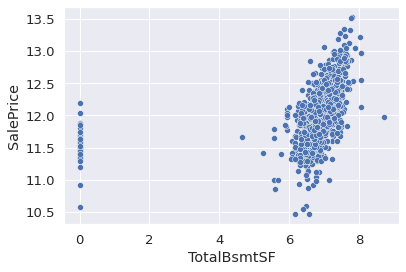

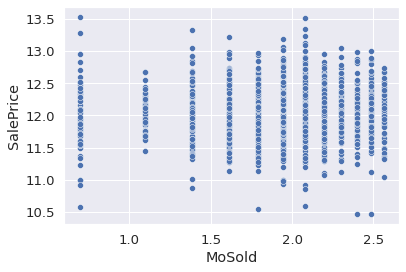

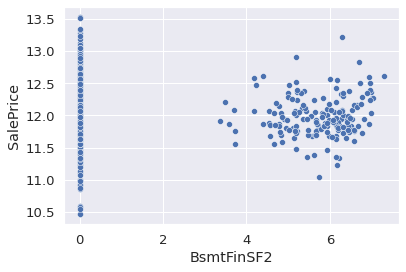

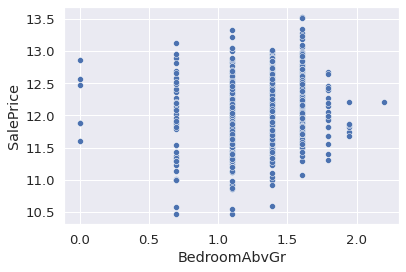

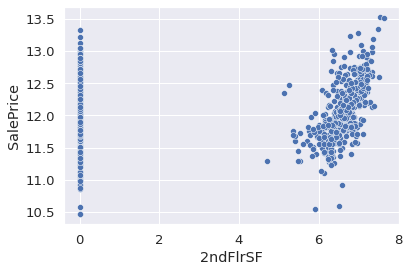

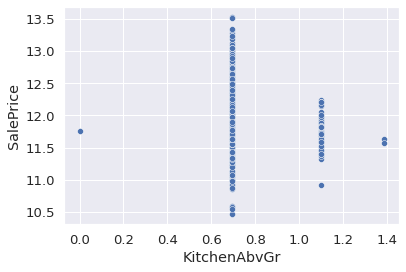

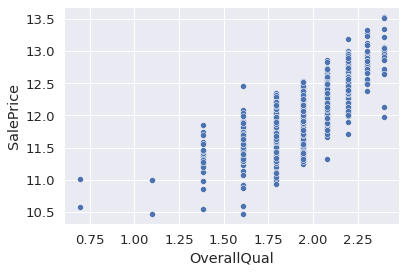

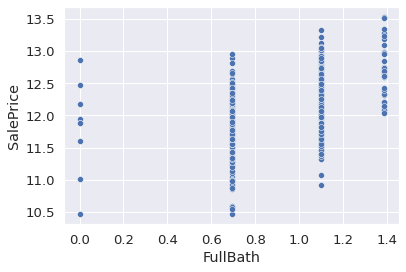

In [38]:
plot_feature_var(dataset_sk, right_skewed)

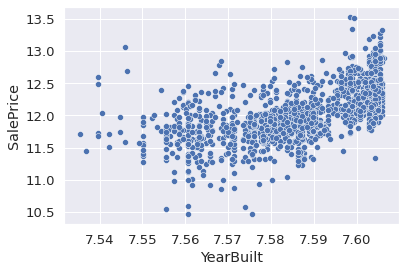

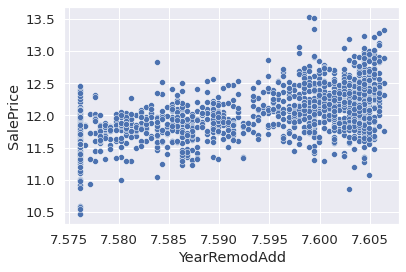

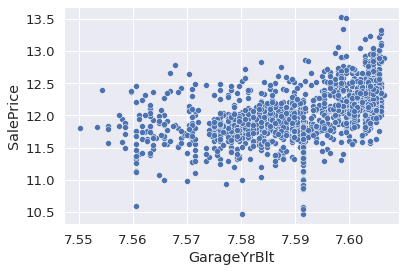

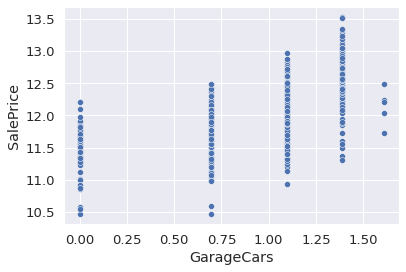

In [39]:
plot_feature_var(dataset_sk, left_skewed)

By inspecting the plots one by one, some conclusions can be deduced:
  - OverallQual seems to have a monotone relationship with SalePrice.
  - TotalBsmtSF also has a relationship with SalePrice when basement is available.
  - 1stFlrSF also has a relationship and possible outliers.
  - GrLivArea may has some outliers similar to 1stFlrSF

In [40]:
# Remove outliers
dataset_sk.drop(dataset_sk[dataset_sk['TotalBsmtSF'] > 8.2].index, inplace=True)
dataset_sk.drop(dataset_sk[dataset_sk['1stFlrSF'] > 8.2].index, inplace=True)
dataset_sk.drop(dataset_sk[dataset_sk['GrLivArea'] > 8.4].index, inplace=True)

Note: the parameter inplace True was used for the second contribution

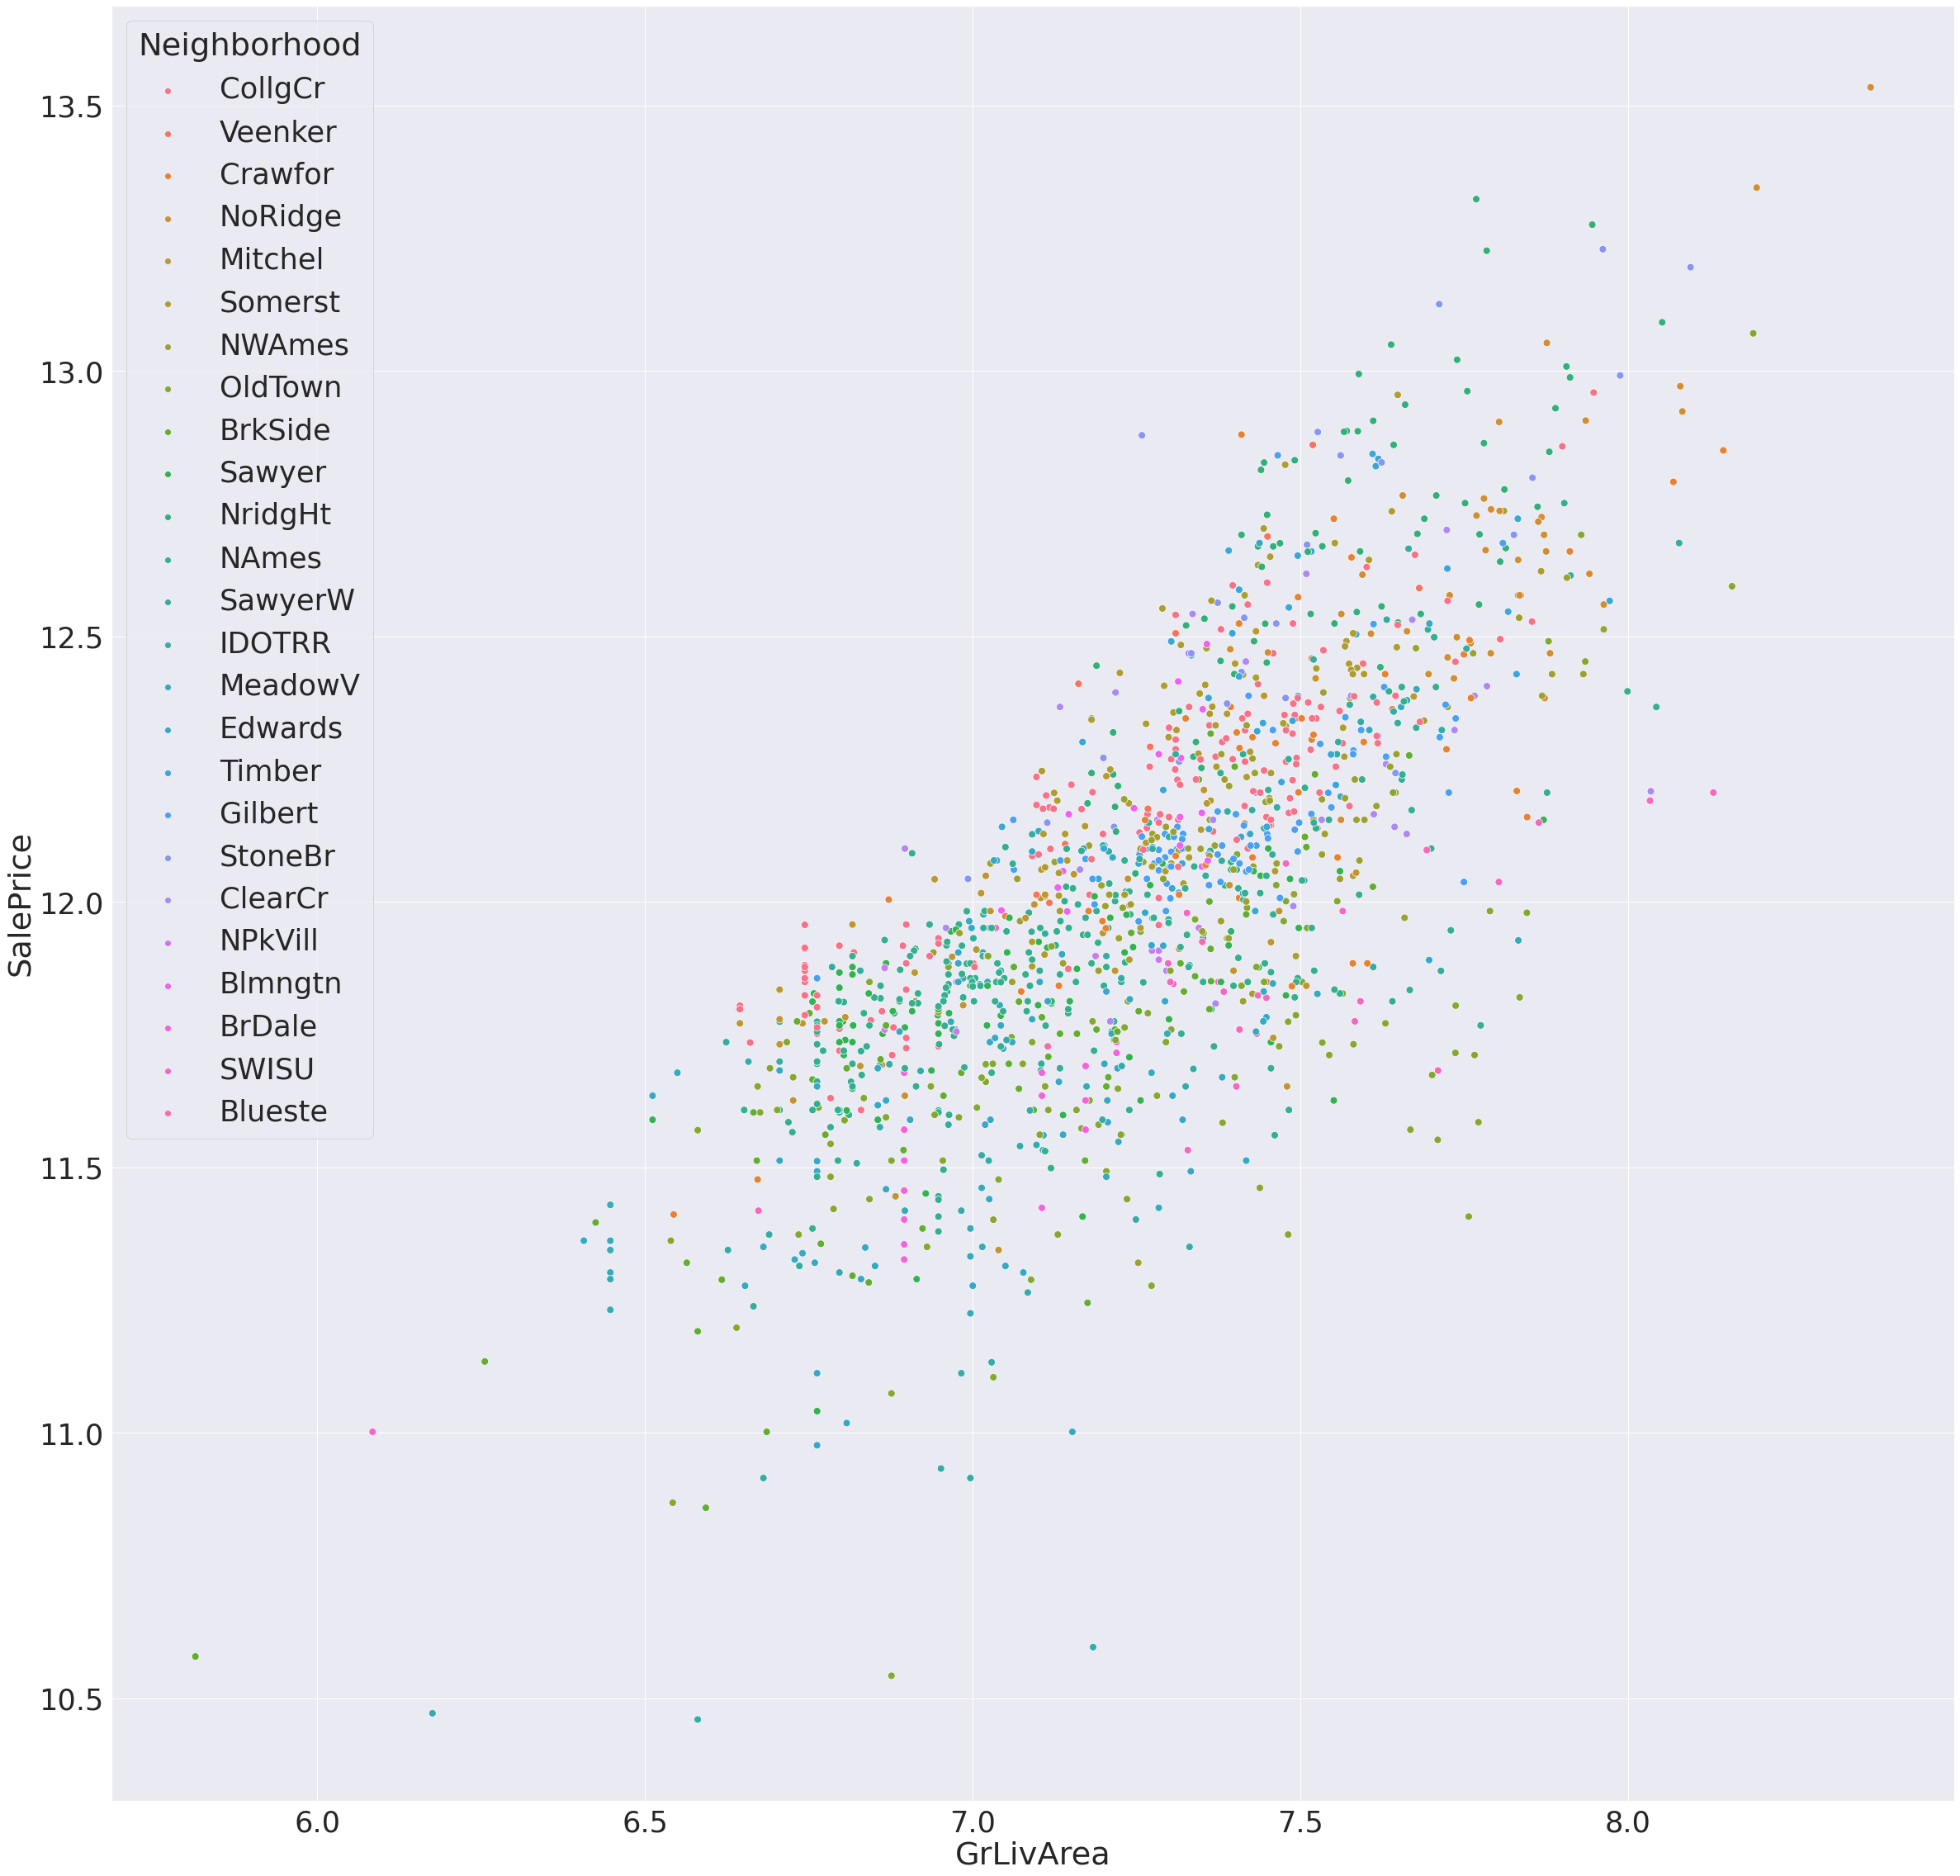

In [41]:
# mpld3.enable_notebook() # to zoom on plots
# 1st Barplot
sns.set(font_scale=3.2)
sns.set_palette("pastel")
plt.figure(figsize=(40, 40))
sns.scatterplot(x='GrLivArea', y="SalePrice", hue="Neighborhood", data=dataset_sk, s=80)

Overall, the feature variables that affect the target variable SalePrice seem to be: OveralQual, GrLivArea, Neighborhood, GarageFinish.

Notes:
   - dataset_sk is the corrected dataset that addresses the skewness.
   - references:  
       -  https://www.stat.cmu.edu/~hseltman/309/Book/chapter4.pdf, http://www.mit.edu/~6.s085/notes/lecture6.pdf
       -  the wonderful group on jitter!

# 2nd contribution

   - Auxiliary functions

In [42]:
def encode_MSSubClass(dataset):
    """Encode the feature column MSSubClass"""
    mapper = {'MSSubClass': {20: '1_N', 30: '1_O', 40: '1_WA', 120: '1_PUD', 45: '1_1_2_U', 
                             50: '1_1_2_F', 60: '2_N', 70: '2_O', 160: '2_PUD', 75: '2_1_2_N',
                             80: 'ML', 85: 'SF', 90: 'DUP_N', 180: 'ML_PUD', 190: '2_CON'}
             }
    dataset.replace(mapper, inplace=True)
    
def print_metrics(X_train, y_train, y_test, y_pred, model):
    """ Print the regression metrics to evaluate the efficiency of a model """ 
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
    MSE_train = mean_squared_error(y_train, model.predict(X_train))
    MSE_test = mean_squared_error(y_test, y_pred)
    MAE_train = mean_absolute_error(y_train, model.predict(X_train))
    MAE_test = mean_absolute_error(y_test, y_pred)
    
    print(f"The R-squared metric (train): {r2_score(y_train, model.predict(X_train))}") 
    print(f"The R-squared metric (test) : {r2_score(y_test, y_pred)}") 
    print(f"The MSE metric is    (train): {MSE_train}") # error achieved at the training
    print(f"The MSE metric is    (test) : {MSE_test}")
    print(f"The MAE metric is    (train): {MAE_train}")
    print(f"The MAE metric is    (test) : {MAE_test}")
    
    return list((MSE_train, MSE_test, MAE_train, MAE_test))
    
def plot_residuals(X_train, y_train, X_test, y_test, model):
    """ Plot the residuals (errors) vs predicted values (theta^T x)"""
    from yellowbrick.regressor import ResidualsPlot
    
    visualizer = ResidualsPlot(model, hist=True, qqplot=False)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show() # note: if i skip show() legends and labels are not visualized
    
def fit_linear_model(dataset, create_dummies):
    """ Fit the linear model"""
    if create_dummies:
        dataset = pd.get_dummies(dataset, drop_first=True) # only for the case where the whole dataset is used
        
    lr_y_r = dataset['SalePrice'].to_numpy() # target variable
    dataset = dataset.drop(columns=['SalePrice'])
    lr_X_r = dataset.to_numpy() # design matrix

    # split the dataset
    from sklearn.model_selection import train_test_split
    lr_X_train_r, lr_X_test_r, lr_y_train_r, lr_y_test_r = train_test_split(lr_X_r, lr_y_r, test_size=0.2, random_state=1) # random seeder
    
    
    from sklearn import linear_model
    # Fit the model using sklearn Linear Regression
    lr_r = linear_model.LinearRegression()

    # Train the model via the train sets
    lr_r.fit(lr_X_train_r, lr_y_train_r)

    # Make predictions via the testing set
    lr_y_pred_r = lr_r.predict(lr_X_test_r)
    
    # Print metrics
    _ = print_metrics(lr_X_train_r, lr_y_train_r, lr_y_test_r, lr_y_pred_r, lr_r)
    
    # Plot Residuals 
    plot_residuals(lr_X_train_r, lr_y_train_r, lr_X_test_r, lr_y_test_r, lr_r)      
    
    # Plot outputs
    results_frame = pd.DataFrame({"Test Values": lr_y_test_r, "Predicted Values": lr_y_pred_r})
    sns.regplot(data=results_frame, x="Predicted Values", y="Test Values")
    return results_frame
    
def find_linear_dependencies(X):
    """ Find the the linearly dependent columns of a matrix """
    # we have a tall matrix X of dimensions (m x n), thus rank <= n.
    from numpy import linalg
    
    mat = X
    mat_r = linalg.matrix_rank(mat)
    print(f"Rank = {mat_r}")
    for i in range(mat.shape[1]): # remove one column at a time, and check the rank of the reduced matrix
        if i == 0:
            new_mat = mat[:, i+1:]
        elif i == mat.shape[1] - 1:
            new_mat = mat[:, :-1]
        else:
            new_mat = np.concatenate((mat[:, :i], mat[:, i+1:]), axis=1)

        if linalg.matrix_rank(new_mat) == mat_r:
            print(f"column {i} does not reduce rank!")
            print(f"column {i} corresponds to {dataset_lg.iloc[:, i].name}")
            
def find_corr_design_mat(dataset, thresh):    
    """ Inspect highly correlated features in the dataset """
    plt.figure(figsize=(44, 40))
    corr = np.abs(dataset.iloc[:, :].corr(method='spearman')) > thresh
    mask = np.zeros_like(corr)
    sns.set(style="whitegrid", font_scale=2.5)
    mask[np.triu_indices_from(mask)] = True # lower triangular
    sns.heatmap(corr, annot=False, annot_kws={"size": 15}, 
                cmap="summer", linewidths=1.5, mask=mask, square=True)
    
    
def feature_importance(model):
    """ Extract the features with nonzero coefficients.
        Note: it works for scikit-learn estimators, and particularly for the regularized models.
    """
    importance = np.abs(model.coef_)                 # magnitude of importance
    nonzero_coeff_l = (model.coef_ != 0)
    nonzero_coeff = nonzero_coeff_l.sum()
    feature_name = dataset_lg_reg.columns.to_list()  # TODO: dataset as a parameter
    importance_frame = pd.DataFrame({'Features': feature_name, 'Importance': importance})
    return nonzero_coeff, importance_frame

def plot_importance(model, importance_frame):
    """ Plots a barplot that illustrates the magnitude of the coefficients.
        Note: it works for scikit-learn estimators, and particularly for the regularized models
    """
    plt.figure(figsize=(24, 10))
    sns.set(style='darkgrid', color_codes=True)
    sns.barplot(y='Features', x='Importance',  palette='pastel', data=importance_frame.sort_values(by='Importance').tail(20))
    plt.title(f"l1_ratio = {model.l1_ratio}")

def elastic_net_cv_l1_tune(lr_X_train, lr_X_test, lr_y_train, lr_y_test, l1_ratio):
    """ Cross validation process with elastic net and fixed l1_ratio. """
    en = ElasticNetCV(cv=5, random_state=1, l1_ratio=l1_ratio)
    en.fit(lr_X_train, lr_y_train)

    print(f"The alpha parameter is: {en.alpha_}")
    print(f"The l1_ratio parameter is: {en.l1_ratio_}")

    # Make predictions using the testing set
    lr_y_pred_en = en.predict(lr_X_test)
    print(f"norm of the parameter theta vector {np.linalg.norm(en.coef_)}")
    
    metrics = print_metrics(lr_X_train, lr_y_train, lr_y_test, lr_y_pred_en, en)

    # We also scale back our data to the original scale
    results_frame_right_scale_en = pd.DataFrame({"Test Values": np.exp(lr_y_test) - 1, "Predicted Values": np.exp(lr_y_pred_en) - 1})
    nonzero_coeff, importance_frame = feature_importance(en)
    print(" * " * 30)
    metrics.append(nonzero_coeff)
    return metrics, en, importance_frame


We proceed with the second contribution. The goal is to fit the given data on a model and try to predict accurately SalePrices on 'unseen' houses. 
Different models will be tested that demand different assumptions on the data. 
For example, different models may require different encoding on data etc. Before each model fitting, the basic characteristics will be briefly noted.

The libraries used for this task are:
  - Scikit-Learn: A machine learning library for python, which implements the majority of regression and classification models.
  - Tensorflow.keras: A Deep Learning framework. 
  - XGBoost: A library that implements a gradient boosting technique variation. 

First, we address the encoding on the MSSubClass feature variable.

In [43]:
# Encode the 'MSSubClass'
encode_MSSubClass(dataset)
encode_MSSubClass(dataset_sk)

#   Linear Regression
 
Linear Regression is one of the simplest models used to explain data. It is heavily used as a benchmark model in a lot of applications. However, linear regression requires some assumptions on the data (normality on residuals, homoscedasticity, independence of features, note: normality of features is not required). 

Note that from the plots above (see cell In[39]), the feature variables do not have a linear relationship with the target variable SalePrice. This is not exactly restrictive since Linear Regression assumes linearity on the parameters ${\theta}$. However, this may be an indication that a linear model will not fit the data well. 

For example, for the features BsmtUnfSF and LotArea, there is no obvious linear trend.

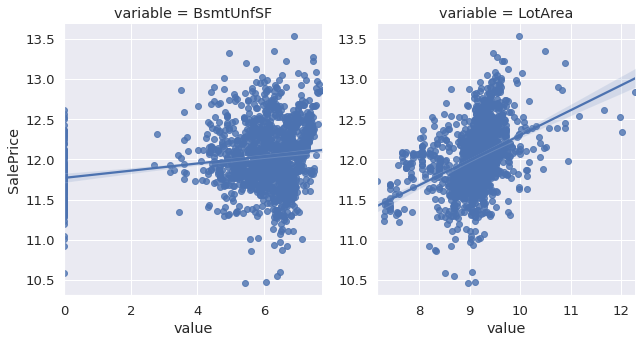

In [44]:
sns.set(font_scale=1.2)
f = pd.melt(dataset_sk, id_vars=['SalePrice'], value_vars=['BsmtUnfSF', 'LotArea'])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5, aspect=0.9)
g = g.map(sns.regplot, "value", "SalePrice")
g.fig.tight_layout()

Although, a linear regression model may lead to an oversimplified analysis, we proceed with fitting the linear model as it may provide additional insights on our data.

  - We start with Linear Regression for the whole dataset. Also, we fit the data that were not ${\log}$ transformed in the previous step, in order to check the effect of ${\log}$ transformation on the regression model fitting. Note that the attention on the linear regression assumptions will be taken care in the next section.

In [45]:
# We will keep a copy of the data for each model
dataset_lg = dataset_sk.copy(deep=True) # log transformed
dataset_lg_r = dataset.copy(deep=True)

The R-squared metric (train): 0.9217153544034642
The R-squared metric (test) : 0.58689777342817
The MSE metric is    (train): 506952516.99677616
The MSE metric is    (test) : 2320488014.544316
The MAE metric is    (train): 15011.240493863488
The MAE metric is    (test) : 20742.367127540354


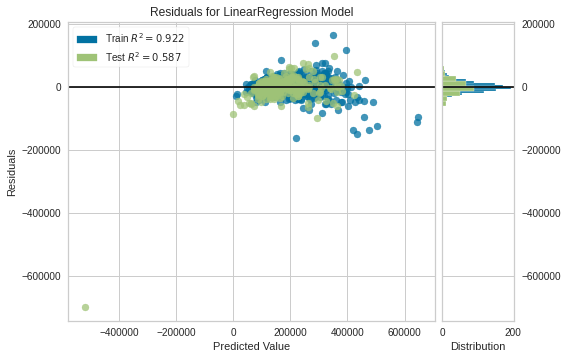

Test Values  Predicted Values
0         181000     152874.592105
1         180000     164334.560419
2         177000     171628.449995
3         174500     160726.589462
4         132000     143063.932513
..           ...               ...
287       228500     244513.198442
288       193000     175910.654069
289       244000     208086.009229
290       424870     364823.140490
291       129500     102304.867355

[292 rows x 2 columns]

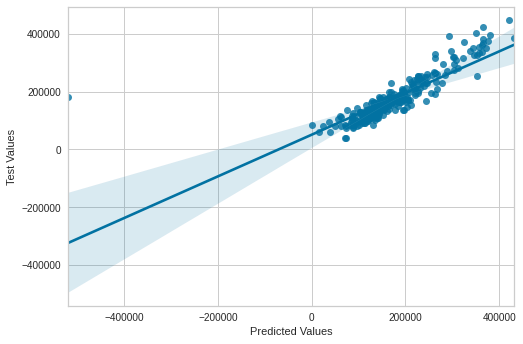

In [46]:
# Use all the feature columns for the regression model 
# (raw dataset, including the outliers removed in the previous step)
fit_linear_model(dataset_lg_r, create_dummies=True)

And, for the ${\log}$ transformed data.

The R-squared metric (train): 0.9459621347967997
The R-squared metric (test) : 0.8908553559418848
The MSE metric is    (train): 0.008487110331881549
The MSE metric is    (test) : 0.017838293972248058
The MAE metric is    (train): 0.06592032880777324
The MAE metric is    (test) : 0.09062784248178232


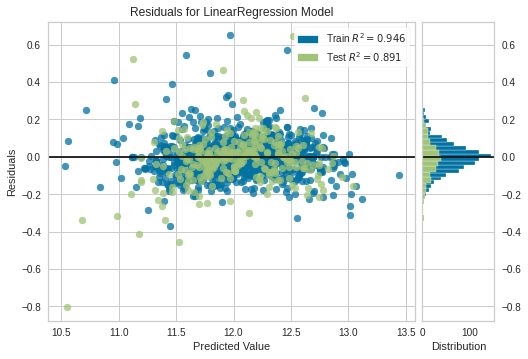

Test Values  Predicted Values
0      12.523530         12.400754
1      12.100718         12.066298
2      12.083911         12.033296
3      12.100718         12.107092
4      11.790565         11.837042
..           ...               ...
287    12.339296         12.411942
288    12.174995         12.185205
289    12.404928         12.307908
290    11.813037         11.768614
291    11.771444         11.789713

[292 rows x 2 columns]

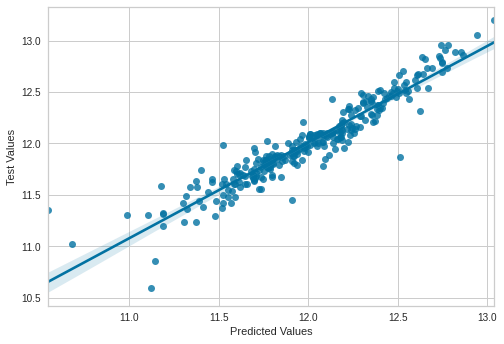

In [47]:
fit_linear_model(dataset_lg, create_dummies=True)

The dimensionality of the feature space has increased due to the dummy variable encoding.

$R^2$ cannot be used to compare different models. For example, the ${\log}$ transformed model cannot be compared with the raw one in terms of $R^2$. To assess the performance of the two models separately, the evaluated metrics are examined. For the first attempt, the achieved ${R^2}$ is much higher when it is evaluated on the train data than the value on the unseen (test) data. Furthermore, the MSE and MAE achieved for the train data are lower than the ones achieved for the test set. This is an indication of overfitting on the train data. The same pattern is observed for the second model too, but in a moderate level.

Quick definitions:
   -  Overfitting: High accuracy on the train set, low/poor accuracy on the test set.
   -  Underfitting: Low accuracy on the train set, low accuracy on the test set.
   -  Good fit: High accuracy on the train set, small accuracy difference on the test set.

- In the sequel, the assumptions of linear regression should be taken into account. In more detail, we examine the correlations between the feature variables. From the correlation heatmap below, we remove features that are highly correlated with each other, in order to avoid linear dependencies between features columns. Features 'PoolQC' and 'PoolArea' have a very strong relationship with each other, thus we choose to remove the feature 'PoolQC' as 'PoolArea' seems more informative.

The threshold is set 0.7 to indicate variables with considerable correlation.

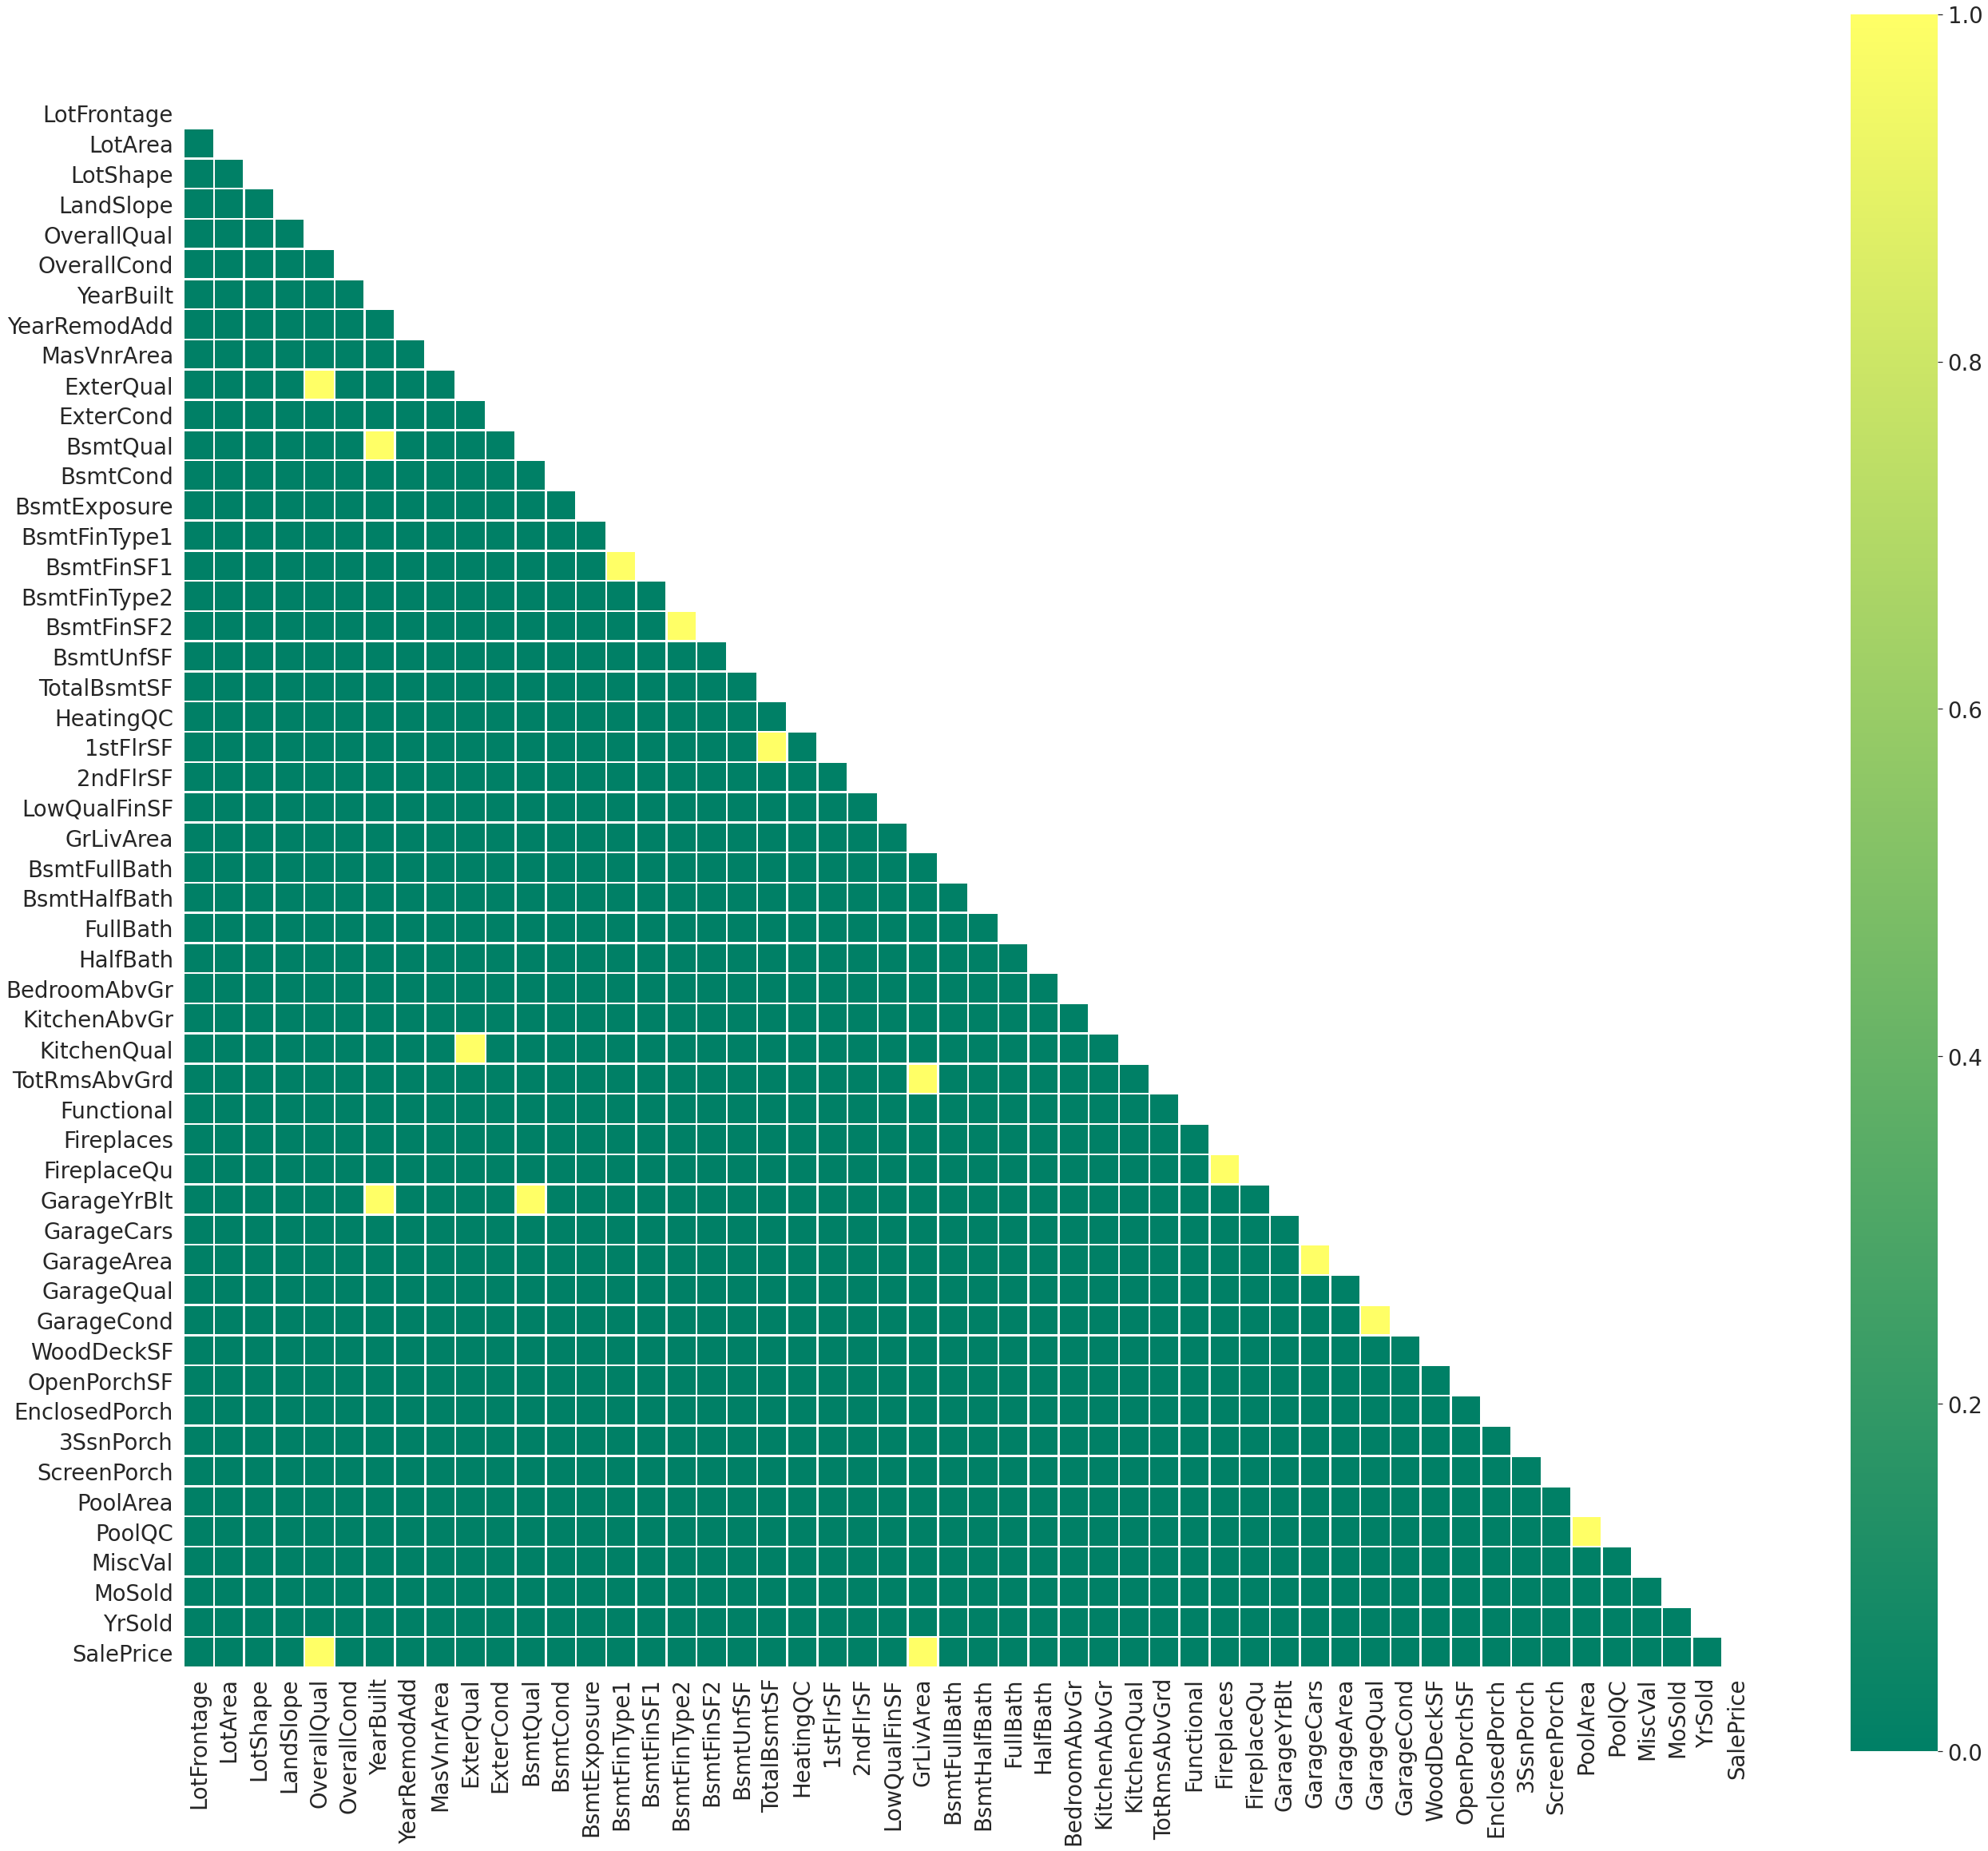

In [48]:
# Plot the new heatmap
find_corr_design_mat(dataset_lg, 0.7)

In [49]:
# Drop PoolQC
dataset_lg = dataset_lg.drop(columns=['PoolQC'])
dataset_lg_r = dataset_lg_r.drop(columns=['PoolQC'])

# for regularization purposes
dataset_lg_reg = pd.get_dummies(dataset_lg) 

Similarly, we drop additional columns that do not have any significant correlation with the target variable and are correlated with a feature variable in the dataset. The selection of these features is done through the available heatmaps and the Kruskal Wallis test from the first contribution. 

In [50]:
cols_to_be_dropped = ['FireplaceQu', 'GarageQual', 'LotConfig', 'YearBuilt', 'Utilities', 'Street', 'BldgType',
                     'BsmtFinSF1', 'BsmtFinSF2', 'TotRmsAbvGrd']  
# Drop the columns on both copies
dataset_lg = dataset_lg.drop(columns=cols_to_be_dropped)
dataset_lg_r = dataset_lg_r.drop(columns=cols_to_be_dropped)

We proceed with the categorical data encoding for linear regression. In order to avoid the dummy variable trap, which will introduce additional (more columns may need to be removed) collinearity in our model, we drop one of the category levels that will be created. Thus, the intercept (parameter $\theta_0$) will carry the influence for the dropped level. 

The Linear Regression model has a closed form solution. The characteristics of the Ordinary Least Squares (OLS) solution depend heavily on the design matrix, namely the dataset without the target.

The use of dummy encoding prevents the linear dependency between the columns of the design matrix ${\bf X}$. In case there are columns in the design matrix that are linearly dependent, the matrix ${{\bf X}^T{\bf X}}$ is not invertible, thus the OLS solution will not be unique.  

In [51]:
# Encode the nominal categorical variables
dataset_lg = pd.get_dummies(dataset_lg, drop_first=True) 
dataset_lg_r = pd.get_dummies(dataset_lg_r, drop_first=True)
dataset_lg.shape

(1456, 205)

In the sequel, the dataset is split to train and test sets with ratio 80% for the train and 20% for the test set.
Parameter random_state set to 1 to produce the same sets to compare.

In [52]:
# It's time to abandon the dataframe and use numpy arrays
lr_y = dataset_lg['SalePrice'].to_numpy() # target variable
dataset_lg = dataset_lg.drop(columns=['SalePrice'])
lr_X = dataset_lg.to_numpy() # design matrix

# split the dataset
from sklearn.model_selection import train_test_split
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=1) # random seeder set to 1 to produce the same sets

By inspecting the rank of the symmetric matrix ${{\bf X}^T{\bf X}}$, we spot its rank deficiency.

In [53]:
find_linear_dependencies(lr_X_train)

Rank = 197
column 103 does not reduce rank!
column 103 corresponds to Condition2_RRAe
column 117 does not reduce rank!
column 117 corresponds to RoofStyle_Shed
column 119 does not reduce rank!
column 119 corresponds to RoofMatl_Metal
column 127 does not reduce rank!
column 127 corresponds to Exterior1st_CBlock
column 141 does not reduce rank!
column 141 corresponds to Exterior2nd_CBlock
column 165 does not reduce rank!
column 165 corresponds to Heating_OthW
column 177 does not reduce rank!
column 177 corresponds to GarageType_Not available
column 178 does not reduce rank!
column 178 corresponds to GarageFinish_Not available
column 190 does not reduce rank!
column 190 corresponds to MiscFeature_TenC


After researching, Sklearn Linear Regression class uses Scipy's OLS method to fit a linear model. The Scipy OLS documentation states that in case the design matrix is singular, the solution of the minimization problem ${\min \| b - ax \|_2^2}$ (plus a norm) is returned. Links available on references.

In [54]:
print(f"Dimensions of lr_X_train: {lr_X_train.shape}")
print(f"Dimensions of lr_X_test: {lr_X_test.shape}")
print(f"Dimensions of lr_y_train: {lr_y_train.shape}")
print(f"Dimensions of lr_y_test: {lr_y_test.shape}")

Dimensions of lr_X_train: (1164, 204)
Dimensions of lr_X_test: (292, 204)
Dimensions of lr_y_train: (1164,)
Dimensions of lr_y_test: (292,)


In [55]:
from sklearn import linear_model
# Fit the model using sklearn Linear Regression
lr = linear_model.LinearRegression()

# Train the model using the training sets
lr.fit(lr_X_train, lr_y_train)

# Make predictions using the testing set
lr_y_pred = lr.predict(lr_X_test)

The $R^2$, ${\tt MAE}$ and ${\tt MSE}$ of the fitted model are:

In [56]:
print(f"Metrics for Multiple Linear Regression: ")
_ = print_metrics(lr_X_train, lr_y_train, lr_y_test, lr_y_pred, lr)

Metrics for Multiple Linear Regression: 
The R-squared metric (train): 0.9433156889805829
The R-squared metric (test) : 0.8919655417261756
The MSE metric is    (train): 0.00890275735170956
The MSE metric is    (test) : 0.017656848326839693
The MAE metric is    (train): 0.06781443784995508
The MAE metric is    (test) : 0.0920187284535077


In the following, the residual errors are visualized.

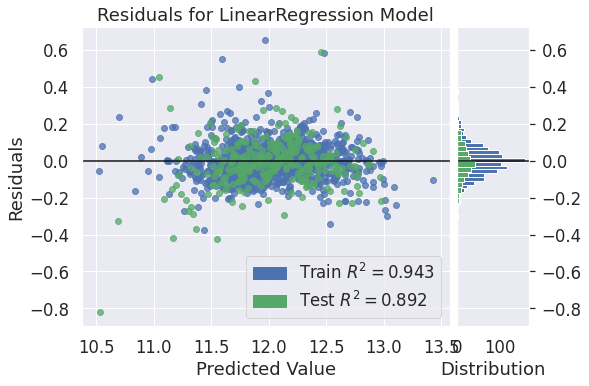

In [57]:
sns.set(font_scale=1.5)
plot_residuals(lr_X_train, lr_y_train, lr_X_test, lr_y_test, lr)

Since our features and target were $\log$ transformed to remove skewness on the data, the parameters $\theta$ (the coefficients) computed correspond to the log scaled model. We highlight that this kind of modeling is still intuitive as it expresses percentage of change.

Test Values  Predicted Values
0       274725.0     240133.047945
1       180000.0     173533.583163
2       177000.0     165274.228334
3       180000.0     181077.087037
4       132000.0     138103.635526
..           ...               ...
287     228500.0     247429.828180
288     193879.0     196416.046558
289     244000.0     218431.388634
290     135000.0     128289.945348
291     129500.0     143913.355020

[292 rows x 2 columns]

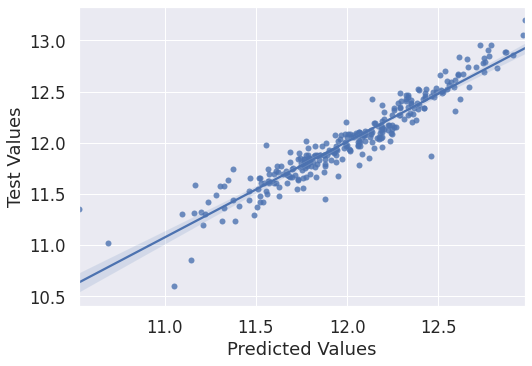

In [58]:
# Plot outputs
results_frame = pd.DataFrame({"Test Values": lr_y_test, "Predicted Values": lr_y_pred})
sns.set(font_scale=1.5)
sns.regplot(data=results_frame, x="Predicted Values", y="Test Values")
# We also scale back our data to the original scale
results_frame_right_scale = pd.DataFrame({"Test Values": np.exp(lr_y_test) - 1, "Predicted Values": np.exp(lr_y_pred) - 1})
results_frame_right_scale

Next we perform cross validation on the fitted model to determine the consistency on our results.

In [59]:
# apply cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
MSEs = cross_val_score(estimator=lr, X=lr_X_train, y=lr_y_train)
print(f"Mean of MSEs after cross validation: {MSEs.mean() :.2f}")
print(f"Standard Deviation: {MSEs.std()*100 :.2f} %")

Mean of MSEs after cross validation: 0.89
Standard Deviation: 2.92 %


From the above results, the log transform assisted to fit a good model. This can explained intuitively and may indicates that our original data may had an exponential relationship. Actually, we can visualize raw 'OverallQual' vs SalePrice, where a slight exponential relationship was initially observed.

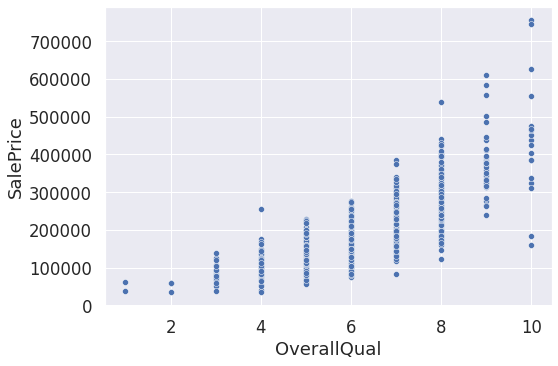

In [60]:
plot_feature_var(dataset, ['OverallQual'])

Next, we examine further the multicollinearity of the feature variables.

  - Ridge Regression is a regression model which includes the ${\ell_2}$ as a regularization term. The use of ${\ell_2}$ helps to address multicollinearity of feature variables. From the mathematical point of view, the regularization term makes matrix ${{\bf X}^T{\bf X}}$ non-singular.

Ridge Regression model is also employed in our analysis. Note that, Ridge regression needs some tuning on the regularization parameter ${\alpha}$, which regulates the penalization on the coefficients. We use the suggested values for ${\alpha}$, and we acquire the fitted model after a cross-validation process.

Also, since in regularized models the multicollinearity is alleviated, the first level of each categorical variable should not be dropped.

In [61]:
lr_y_reg = dataset_lg_reg['SalePrice'].to_numpy() # target variable
dataset_lg_reg = dataset_lg_reg.drop(columns=['SalePrice'])
lr_X_reg = dataset_lg_reg.to_numpy() # design matrix

# split the dataset
from sklearn.model_selection import train_test_split
lr_X_train_reg, lr_X_test_reg, lr_y_train_reg, lr_y_test_reg = train_test_split(lr_X_reg, lr_y_reg, test_size=0.2, random_state=1) # random seeder set to 1 to produce the same sets

In [62]:
# Ridge Regression
from sklearn.linear_model import RidgeCV, Ridge

# Fit ridge regression
lr_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1.5]).fit(lr_X_train_reg, lr_y_train_reg)

# Predict 
lr_ridge_y_pred = lr_ridge.predict(lr_X_test_reg)

In [63]:
# Print the metrics for ridge regression
_ = print_metrics(lr_X_train_reg, lr_y_train_reg, lr_y_test_reg, lr_ridge_y_pred, lr_ridge)
lr_ridge.alpha_

The R-squared metric (train): 0.9424994429054195
The R-squared metric (test) : 0.9089394104733359
The MSE metric is    (train): 0.009030955800553284
The MSE metric is    (test) : 0.014882686908557196
The MAE metric is    (train): 0.06829046712782345
The MAE metric is    (test) : 0.08732877856080981


1.5

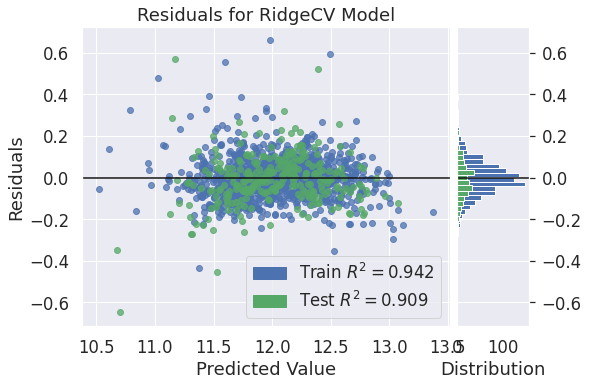

In [64]:
sns.set(font_scale=1.5)
plot_residuals(lr_X_train_reg, lr_y_train_reg, lr_X_test_reg, lr_y_test_reg, lr_ridge)

Plot the validation curve for the Ridge Regression model. We use a bigger range for parameter ${\alpha}$ to visualize better its effect on the regression score. 

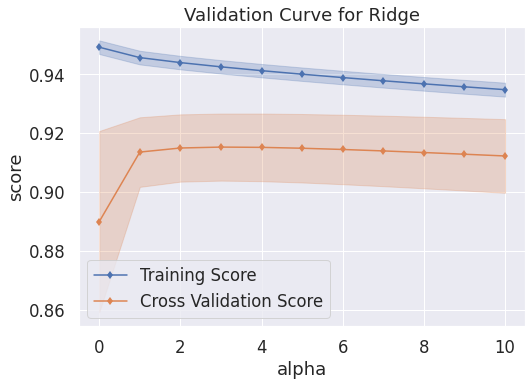

In [65]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(linear_model.Ridge(), param_name="alpha", param_range=np.arange(1e-5, 10.5), cv=5, scoring="r2")
viz.fit(lr_X_train_reg, lr_y_train_reg)
viz.show()

Since the linear model with the existing features may overfits, Polynomial linear Regression will not be tested.

 - Elastic Net penalty

We proceed with adding a penalty to the previous linear model. Elastic net is a regularization (penalty) consisting of ${\ell_1}$ and ${\ell_2}$ norms of the parameter ${\theta}$. Elastic net penalty through ${\ell_2}$ norm makes the cost function we worked previously strongly convex thus we can guarantee that our solution is unique. In addition, due to ${\ell_1}$ penalty which induces sparsity, the coefficients of the less important features will be shrank to zero providing an other way to select variables.

We will tune the elastic net regularization by setting different values for ${\tt l1\_ratio}$ parameter, which regulates the effect of the two norms in the Least Squares cost function. Namely:
   - we set ${\tt l1\_ratio}$ = [0.1, 0.3, 0.5, 0.8, 0.9, 1]
   - Note the ${\tt l1\_ratio}$ = 1 is equal to Lasso.
   - The parameter ${\alpha}$ is selected through a cross-validation process for each one ${\tt l1\_ratio}$ values.

Ridge regression that was visited before, can be achieved through elastic net penalty, if we set ${\tt l1\_ratio}$=0. However, due to the complexity of the tuning for the elastic net regularization parameters, ridge regression was examined separately.

In [66]:
# CV for each l1_value to capture the performance with different regularization levels.
l1_ratio_v = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1]
results = []
models = []
importance_frames = []
for l1_ratio in l1_ratio_v:
    model_info, model, importance_frame = elastic_net_cv_l1_tune(lr_X_train_reg, lr_X_test_reg, lr_y_train_reg, lr_y_test_reg, l1_ratio)
    results.append(model_info)
    models.append(model)
    importance_frames.append(importance_frame)

The alpha parameter is: 4.385571236962744
The l1_ratio parameter is: 0.0001
norm of the parameter theta vector 0.07421132088584032
The R-squared metric (train): 0.6525932164296389
The R-squared metric (test) : 0.6794625787220021
The MSE metric is    (train): 0.05456321583242573
The MSE metric is    (test) : 0.052387735552270616
The MAE metric is    (train): 0.17282782913087943
The MAE metric is    (test) : 0.16812884667398603
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
The alpha parameter is: 0.4385571236962744
The l1_ratio parameter is: 0.001
norm of the parameter theta vector 0.16158932605674514
The R-squared metric (train): 0.8285123301138813
The R-squared metric (test) : 0.8271082085908563
The MSE metric is    (train): 0.026933609782841185
The MSE metric is    (test) : 0.028256948631421034
The MAE metric is    (train): 0.11909625717190853
The MAE metric is    (test) : 0.12564182522601425
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 

Bar plot that illustrate the importance of feature variable in the fitted models

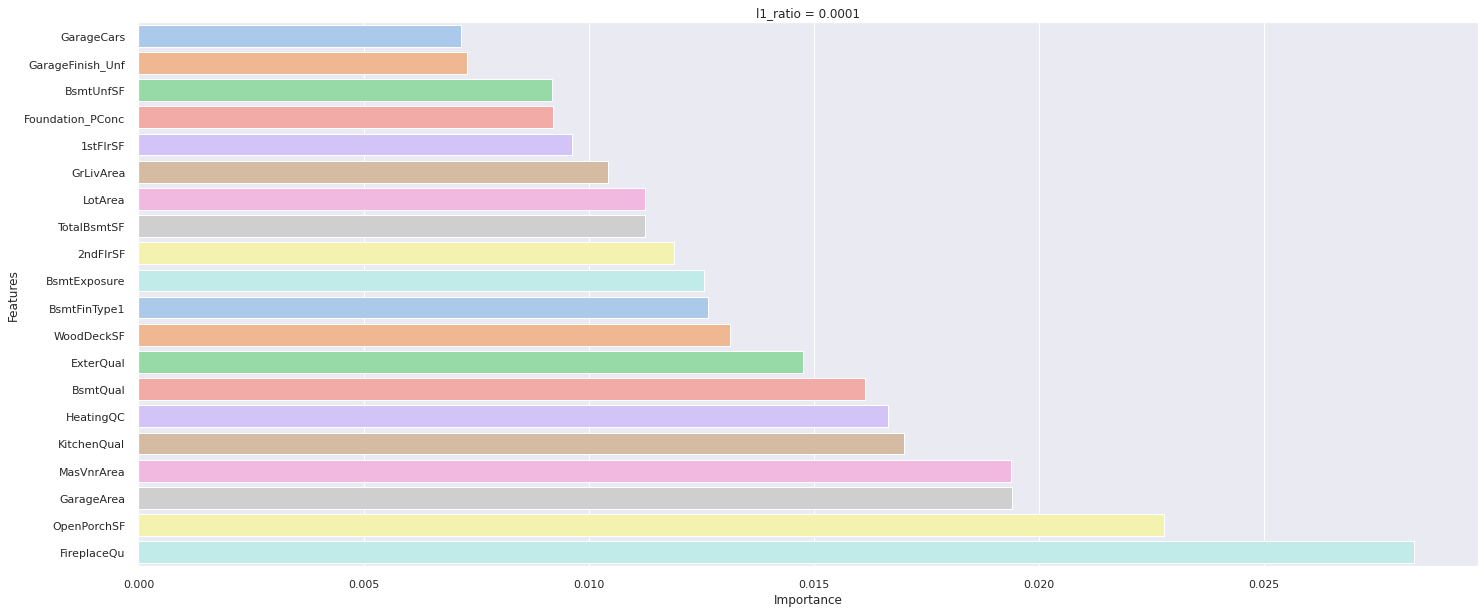

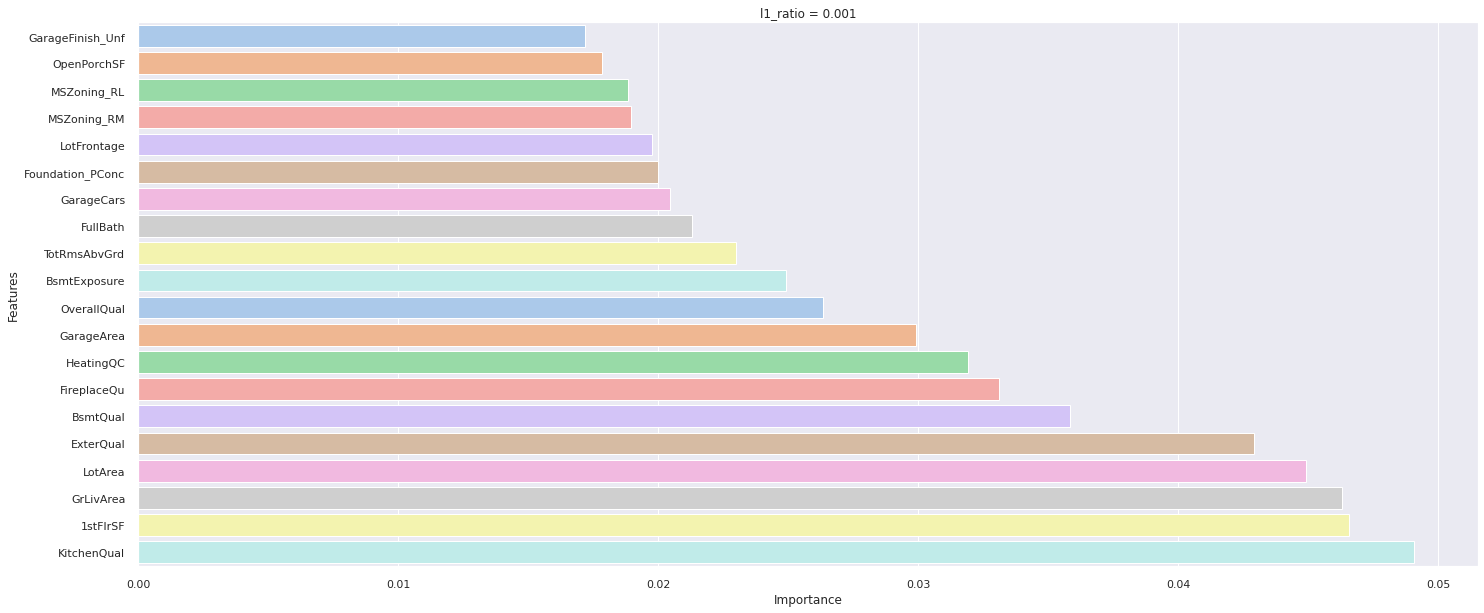

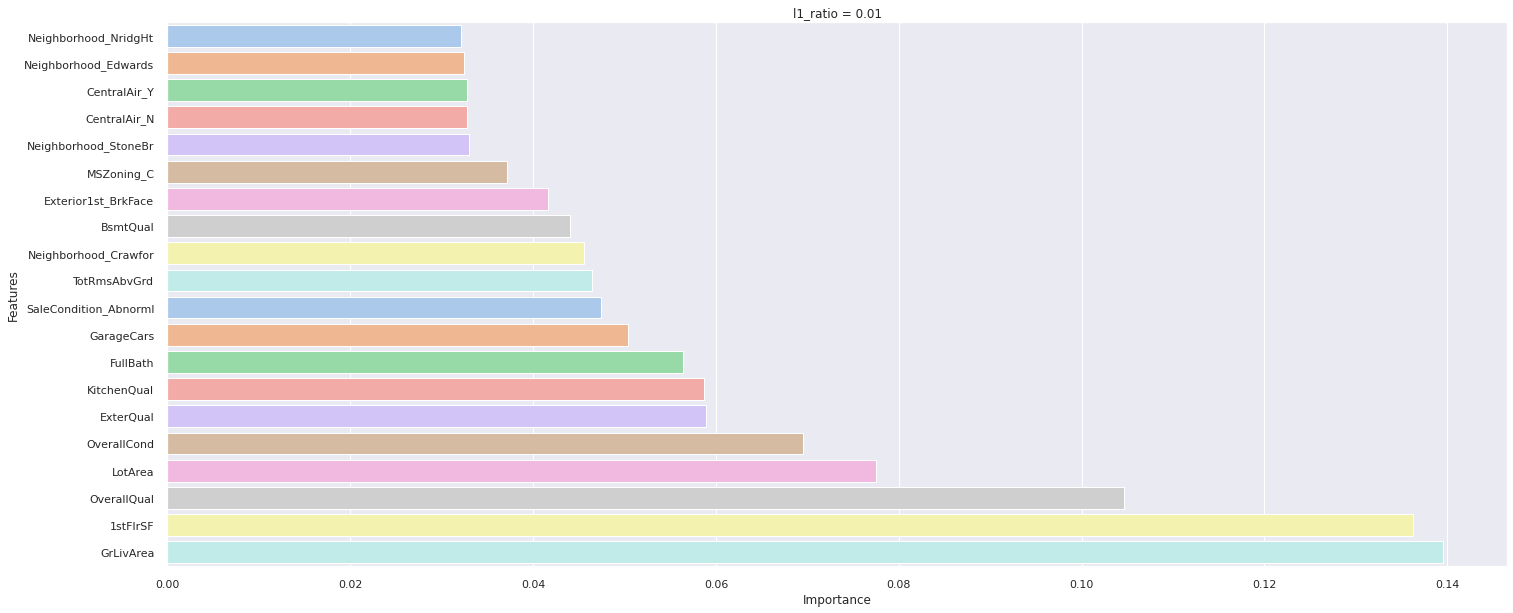

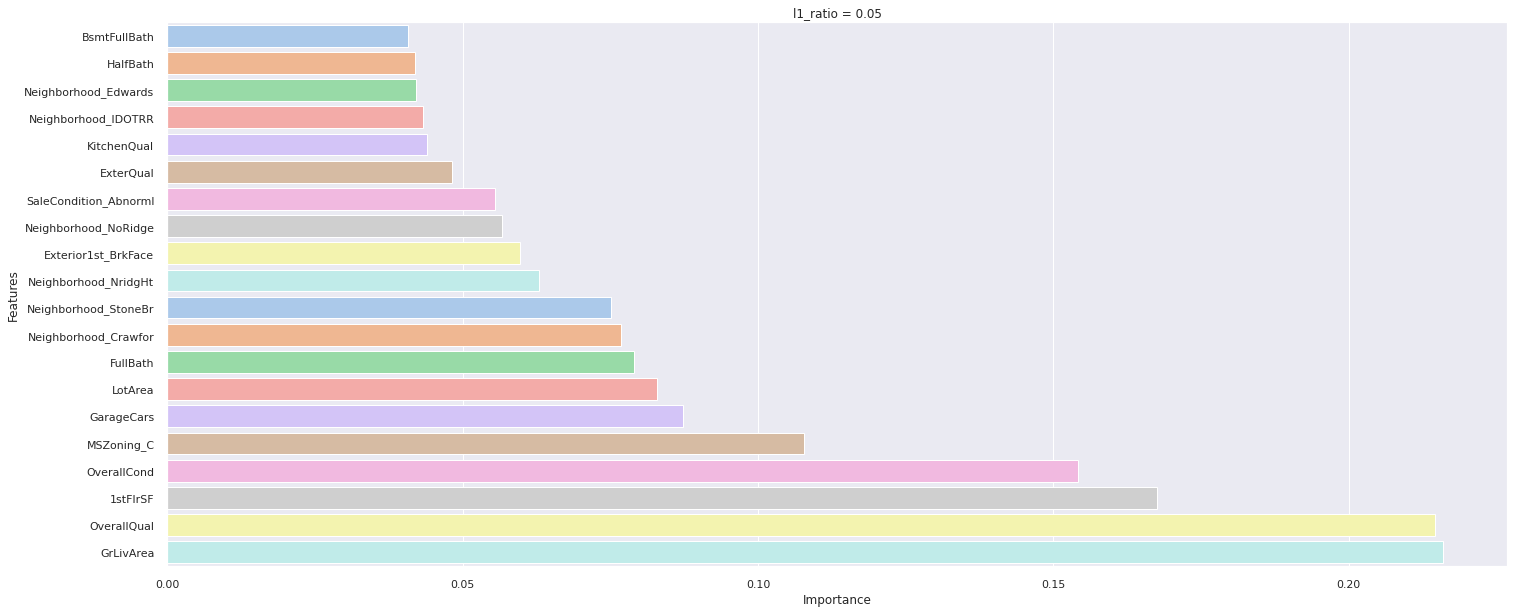

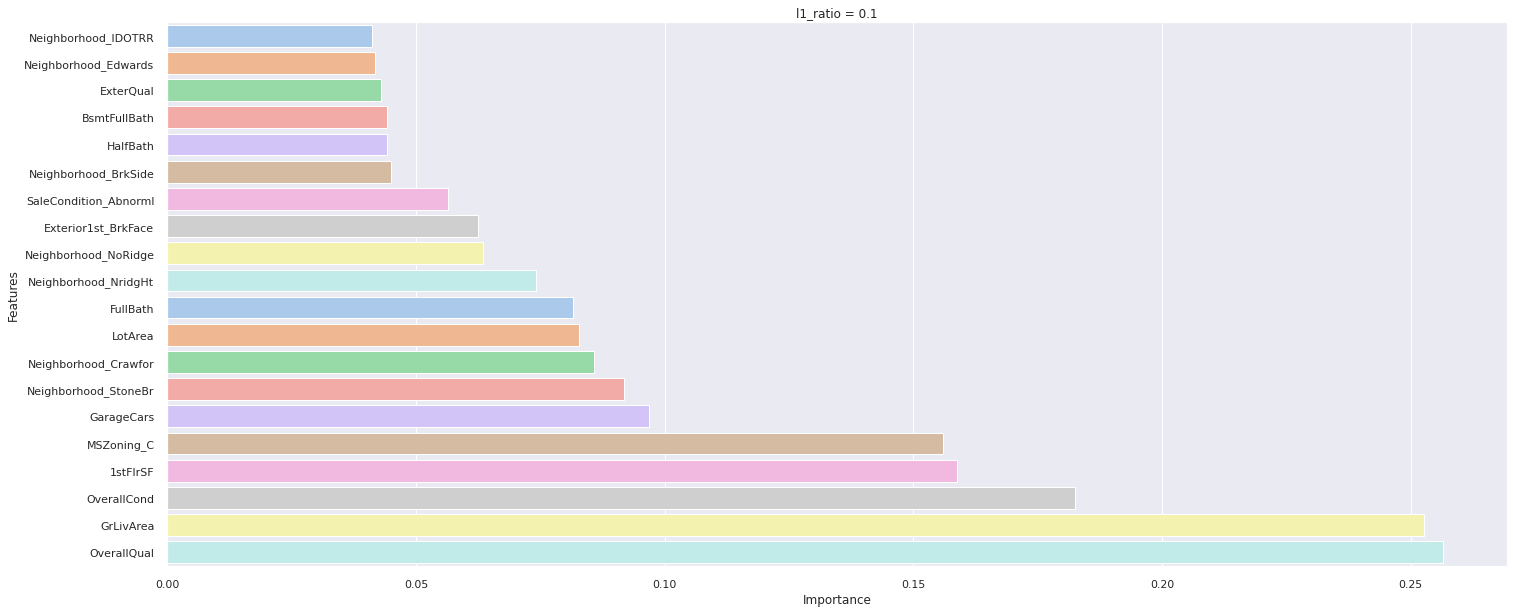

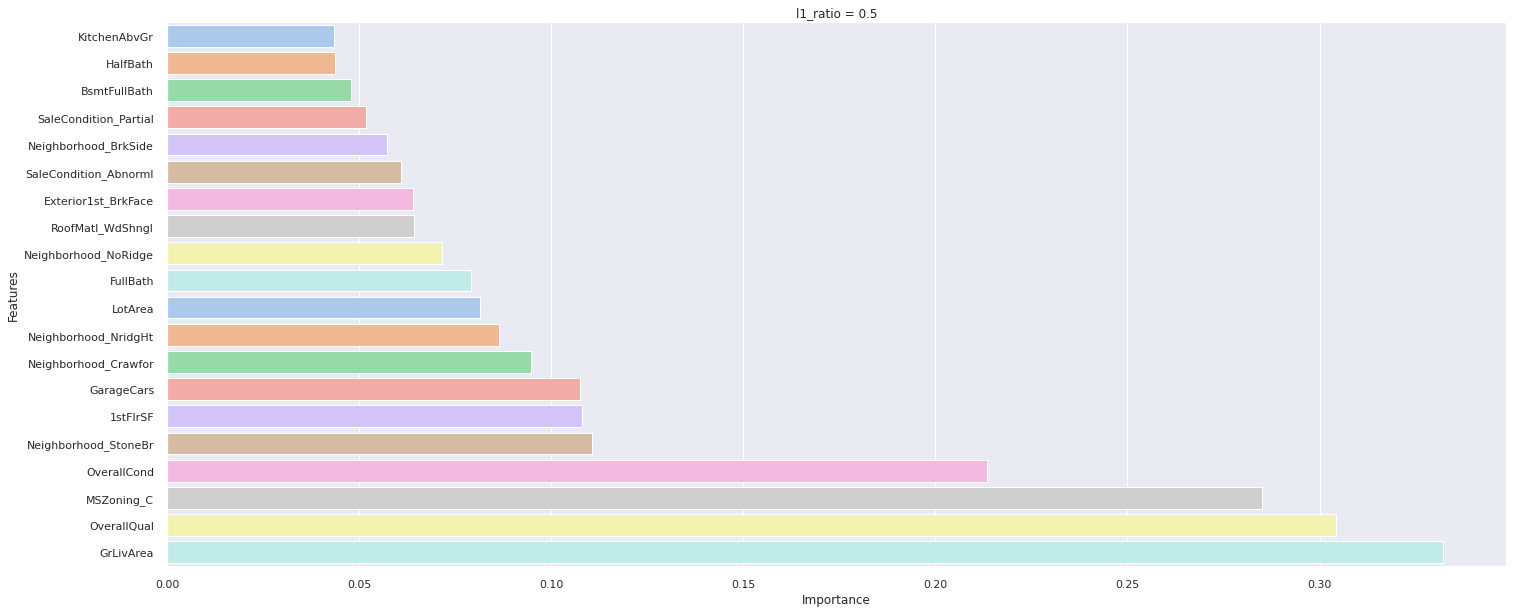

In [67]:
# Barplots
for i in range(len(importance_frames) - 1):
    plot_importance(models[i], importance_frames[i])
    

From the above experiments, it is obvious that the parameter ${\tt l1\_ratio}$ affects the performance of the regression model. In more detail, for small values of ${\tt l1\_ratio}$  the penalty is reduced to the ${\ell_2}$ penalty. Also, in lower ${\tt l1\_ratio}$, the number of nonzero coefficients increases. However, the magnitude of each coefficient is lower. The ${\ell_2}$ penalty still shrinks the coefficients but not to zero, thus it takes into account all the features.

Summarizing the results

In [68]:
# create a frame with the results for each model
results_cv = pd.DataFrame(data=np.array(results), columns=["MSE (train)", "MSE (test)", "MAE (train)", "MAE (test)", "# features"])
results_cv["l1_ratio"] = l1_ratio_v
results_cv.set_index(["# features"])

MSE (train)  MSE (test)  MAE (train)  MAE (test)  l1_ratio
# features                                                            
195.0          0.054563    0.052388     0.172828    0.168129    0.0001
180.0          0.026934    0.028257     0.119096    0.125642    0.0010
136.0          0.014708    0.017461     0.087413    0.097402    0.0100
118.0          0.011480    0.014318     0.077477    0.088515    0.0500
116.0          0.010916    0.013850     0.075529    0.086845    0.1000
114.0          0.010409    0.013586     0.073644    0.085843    0.5000
112.0          0.010347    0.013608     0.073410    0.085765    1.0000

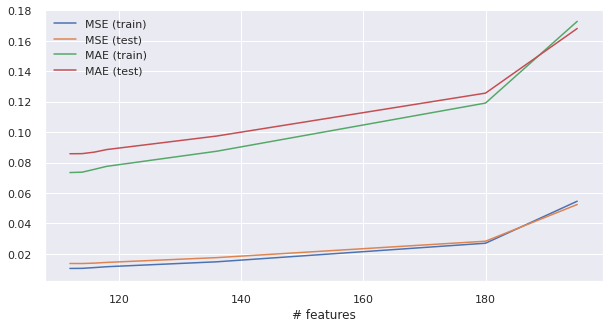

In [69]:
results_cv.iloc[:, :-1].plot(x="# features", figsize=(10, 5), grid=True)

The model with ${\tt l1\_ratio} = 0.5$ achieved the lowest MSE and MAE.

In [70]:
# The features selected by the most efficient model using the elastic net penalty
opt_model = models[5]
mask = (opt_model.coef_ != 0)
list_important_features = np.array(dataset_lg_reg.columns.to_list())
list_important_features = list(list_important_features[mask])

However, it can be observed that some levels of the categorical variables are excluded from the model. It is not possible to leave out some levels of the categorical variables thus, we include all the levels of the corresponding variables. 

In [71]:
fun = lambda string: string.split(sep='_')[0]

In [72]:
important_features = set(map(fun, list_important_features))
important_features = list(important_features)
print(f"Number of Chosen Features: {len(important_features)}")

Number of Chosen Features: 65


In the variable important features, we store the feature variables that elastic-net identified as most important.

# Regression Using an ANN

In the sequel, a Artificial Neural Network is employed to predict the prices of the houses contained on the test set. The use of an ANN may capture any non linearities that may exist on the data and achieve better performance. The Keras library will be used to build and train a simple network 

In [73]:
# create a copy of the dataset
dataset_ann = dataset_sk.copy(deep=True)
dataset_ann = dataset_ann.loc[:, important_features]
dataset_ann.shape

(1456, 65)

In a similar manner, the categorical variables are dummified to get processed in the network.

In [74]:
# Dummyify the categorical variables
dataset_ann = pd.get_dummies(dataset_ann, drop_first=True)

ann_y = dataset_sk['SalePrice'].to_numpy() # target variable
ann_X = dataset_ann.to_numpy() # design matrix
# ann_X = dataset_ann.drop(columns=["SalePrice"]).to_numpy() # design matrix

Scaling the features that are fed in the ANN is not essential but makes the network more stable. Since the training algorithm is (stochastic) gradient descend, scaling may speed up its convergence.

In [75]:
# Splitting the dataset into the train set and test set
from sklearn.model_selection import train_test_split
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(ann_X, ann_y, test_size = 0.2, random_state = 1)

# Feature Scaling after splitting
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ann = sc.fit_transform(X_train_ann)
X_test_ann = sc.transform(X_test_ann)

In this block of code, the architecture of the network is defined as well as the metrics and the learning rate of the optimization algorithm. The number of nodes is selected randomly. The training process follows where the MSE desceases rapidly. Finally, the house prices for the test set are predicted using the weights returned from the network.

In [76]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

# Define the model architecture
ann = tf.keras.Sequential(
      [layers.Dense(2, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name="Hidden1"),
       layers.Dense(3, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01), name="Hidden2"),
       layers.Dense(1, name="Output3")])

# Build the model, declare the main parameters
ann.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1),
            loss="mean_squared_error",
            metrics=[tf.keras.metrics.MeanSquaredError()])

# Train the ann
model_info = ann.fit(x=X_train_ann, y=y_train_ann, batch_size=32,
                      epochs=15, validation_split = 0.2) 

# Save the MSE evolution during training
model_info = pd.DataFrame(model_info.history)
MSE = model_info["mean_squared_error"]

# Predict the SalePrice values
y_pred_ann = ann.predict(X_test_ann)
model_info

Epoch 1/15
30/30 [==============================] - 1s 10ms/step - loss: 77.5740 - mean_squared_error: 77.0156 - val_loss: 12.7520 - val_mean_squared_error: 11.4447
Epoch 2/15
30/30 [==============================] - 0s 1ms/step - loss: 7.7808 - mean_squared_error: 6.4403 - val_loss: 1.3494 - val_mean_squared_error: 0.3305
Epoch 3/15
30/30 [==============================] - 0s 2ms/step - loss: 1.1896 - mean_squared_error: 0.2856 - val_loss: 0.7524 - val_mean_squared_error: 0.1028
Epoch 4/15
30/30 [==============================] - 0s 1ms/step - loss: 0.7011 - mean_squared_error: 0.1029 - val_loss: 0.5689 - val_mean_squared_error: 0.1025
Epoch 5/15
30/30 [==============================] - 0s 1ms/step - loss: 0.5291 - mean_squared_error: 0.0966 - val_loss: 0.4403 - val_mean_squared_error: 0.0986
Epoch 6/15
30/30 [==============================] - 0s 1ms/step - loss: 0.4082 - mean_squared_error: 0.0913 - val_loss: 0.3322 - val_mean_squared_error: 0.0821
Epoch 7/15
30/30 [=================

loss  mean_squared_error   val_loss  val_mean_squared_error
0   46.003342           45.149364  12.752025               11.444654
1    4.538221            3.255673   1.349357                0.330548
2    1.031142            0.213136   0.752363                0.102760
3    0.661085            0.104375   0.568875                0.102541
4    0.507933            0.103409   0.440261                0.098633
5    0.384510            0.088162   0.332215                0.082083
6    0.293179            0.076712   0.278642                0.096447
7    0.234824            0.077654   0.198176                0.066906
8    0.169783            0.056253   0.156406                0.060500
9    0.126793            0.044267   0.117045                0.047330
10   0.097904            0.037153   0.095166                0.043523
11   0.076570            0.032056   0.072607                0.033753
12   0.069382            0.031537   0.073977                0.034374
13   0.055402            0.026463   0.055950                0.033513
14   0.049102            0.026544   0.053617                0.029412

In [77]:
y_test_ann = y_test_ann.reshape(len(y_test_ann),1)
print(f"The R-squared metric (train): {r2_score(y_train_ann, ann.predict(X_train_ann))}") 
print(f"The R-squared metric (test) : {r2_score(y_test_ann, y_pred_ann)}") 

The R-squared metric (train): 0.75363265876612
The R-squared metric (test) : 0.6380294908265944


The ${R^2}$ does not seem ideal. The ANN requires a lot of tuning not only on the parameters like the learning rate but also on the number of neurons for each layer. Models with more epochs and different learning rates were trained, but the MSE had oscillatory behavior.

# Boosting

Finally, Xgboost algorithm will be used to train a regression model. Xgboost implements a variation of gradient boosting technique. In more detail. Gradient boosting is an ensemble method, where a group of simple regressors (in this case) 'cooperate' in a specific way to evaluate the wanted outcome. The predictors are set sequentially and each of them, corrects the outcome of the previous one.

The simple predictors of the XGBoost are decision trees thus, similarly to the regularized models, we do not need to drop the first level of each categorical variable.

Since, XGboost is immune to multicollinearity and does not require certain characteristics on the data, the whole dataset will be used in order to examine the algorithm's feature selection performance and compare the results with previous findings.

In [78]:
from xgboost import XGBRegressor

In [79]:
# create a copy of the dataset
dataset_boost = dataset_sk.copy(deep=True)
dataset_boost.shape

(1456, 80)

Get the encoding for the categorical variables by keeping all the levels.

In [80]:
dataset_boost = pd.get_dummies(dataset_boost) 

Pop the target from the dataset and split to train and test sets.

In [81]:
y_boost = dataset_boost['SalePrice'].to_numpy() # target variable
dataset_boost = dataset_boost.drop(columns=['SalePrice'])
X_boost = dataset_boost.to_numpy() # design matrix

# split the dataset
from sklearn.model_selection import train_test_split
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost, test_size=0.2, random_state=1) # random seeder set to 1 to produce the same sets

In [82]:
# Training XGBoost on the Training set
from xgboost import XGBRegressor
model_boost = XGBRegressor(learning_rate=0.1, n_estimators=1000, reg_alpha=0.5)

Perform grid search, to find the best parameters for the xgboost regression. We highlight that GridSearchCV for XGBoost takes some time for this parameter setting. For model fitting without grid search, set grid_search = False.

In [83]:
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate': [0.05, 0.15, 0.25], 'reg_alpha': [0.01, 1],
              'n_estimators': [100]}
grid_search = False
if grid_search:
    model_boost = GridSearchCV(estimator=model_boost,
                               param_grid=parameters,
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               cv=5,
                               n_jobs=-1)

model_boost.fit(X_train_boost, y_train_boost)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

The predicted values for the test set.

In [84]:
# Predict the values
y_pred_boost = model_boost.predict(X_test_boost)

In [85]:
_ = print_metrics(X_train_boost, y_train_boost, y_test_boost, y_pred_boost, model_boost)

The R-squared metric (train): 0.9902064434833968
The R-squared metric (test) : 0.9121221609590027
The MSE metric is    (train): 0.0015381620718245117
The MSE metric is    (test) : 0.01436250711143028
The MAE metric is    (train): 0.0271766595641249
The MAE metric is    (test) : 0.0863865203301817


The results achieved for the train and test sets have a large difference, thus, we may conclude that this model may overfits on the train data. Better tuning of the parameters may provide better results for this model.  

# Summary
- Log transformation proved beneficial for this dataset
- The model achieved the best values on the performance metrics is with Elastic net penalty with ${\tt l1\_ratio}$ = 0.5.

The predicted values for this model:

In [86]:
lr_y_pred_opt = opt_model.predict(lr_X_test_reg)
results_frame_right_scale = pd.DataFrame({"Test Values": np.exp(lr_y_test_reg) - 1, "Predicted Values": np.exp(lr_y_pred_opt) - 1})
results_frame_right_scale

Test Values  Predicted Values
0       274725.0     247534.278942
1       180000.0     174440.344332
2       177000.0     179755.774757
3       180000.0     183913.412142
4       132000.0     143801.204161
..           ...               ...
287     228500.0     242067.246105
288     193879.0     198615.221559
289     244000.0     226680.279700
290     135000.0     128823.797067
291     129500.0     145447.512479

[292 rows x 2 columns]

And the selected variables

In [87]:
important_features

['ExterQual',
 'OpenPorchSF',
 'LotConfig',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'Exterior2nd',
 'LandContour',
 'Fireplaces',
 'PoolArea',
 'LotArea',
 'PavedDrive',
 'GarageArea',
 'HalfBath',
 'Neighborhood',
 'BsmtCond',
 'MSZoning',
 '1stFlrSF',
 'LotFrontage',
 'GarageFinish',
 'GrLivArea',
 'HeatingQC',
 'FireplaceQu',
 'BsmtUnfSF',
 'GarageType',
 'SaleType',
 'LotShape',
 'MasVnrArea',
 'Exterior1st',
 'MasVnrType',
 'MiscVal',
 'WoodDeckSF',
 'ScreenPorch',
 'Alley',
 'CentralAir',
 'BsmtFinSF1',
 'Foundation',
 'GarageCars',
 'MSSubClass',
 'BsmtFinType1',
 'HouseStyle',
 'EnclosedPorch',
 'RoofMatl',
 'LowQualFinSF',
 'RoofStyle',
 'Heating',
 'BsmtExposure',
 'Fence',
 'OverallCond',
 'BsmtQual',
 '3SsnPorch',
 'SaleCondition',
 'TotalBsmtSF',
 'GarageCond',
 'GarageQual',
 'MoSold',
 'BsmtFinSF2',
 'BedroomAbvGr',
 '2ndFlrSF',
 'BldgType',
 'KitchenAbvGr',
 'OverallQual',
 'FullBath',
 'BsmtFinType2',
 'Condition1']

- It seemed strange at first but linear models with some processing have good performance despite their simplicity. Conclusion, start with simple approaches.

# Notes
- Sklearn API uses the convention of greater is better for cross validation (methods: gridSearch, cross_val_score). In case we want to use a different metric like MSE for scoring which smaller is better, we need to explicitly specify via greater_is_better=False.
- Pandas profiler is a very useful library for EDA. Really thankful to the community for sharing new things!

# References:
- $R^2$: https://data.library.virginia.edu/is-r-squared-useless/ , https://statisticsbyjim.com/regression/interpret-r-squared-regression/
- ${\tt MSE}$: https://en.wikipedia.org/wiki/Mean_squared_prediction_error
- Dummy variables: https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn
- LS: https://math.stackexchange.com/questions/1745101/least-squares-with-singular-aat, 
https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Linear_least-squares, http://netlib.org/lapack/lug/node27.html, http://netlib.org/lapack/lug/node27.html, 
- Singularity of a matrix: https://stats.stackexchange.com/questions/70899/what-correlation-makes-a-matrix-singular-and-what-are-implications-of-singularit/70910#70910 
- XGBoost feature importance: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7